# Train Log 20181201

* Add multi-model training structure

## Results
```

```

## Trained model
* [Download link]()

## Evaluation
* Incorrect sample
![results]()

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import time , datetime

# sys.path.append( os.path.abspath('../../../Dataset/scripts'))
# from utils import *

sys.path.append( os.path.abspath('../../model') )
from train import *

import multiprocessing

import tensorflow as tf


In [2]:
""" Path """
data_train_path = os.path.abspath('../../../new_dataset/dataset/dataset_20181203_01/train.h5')
data_vali_path = os.path.abspath('../../../new_dataset/dataset/dataset_20181203_01/vali.h5')


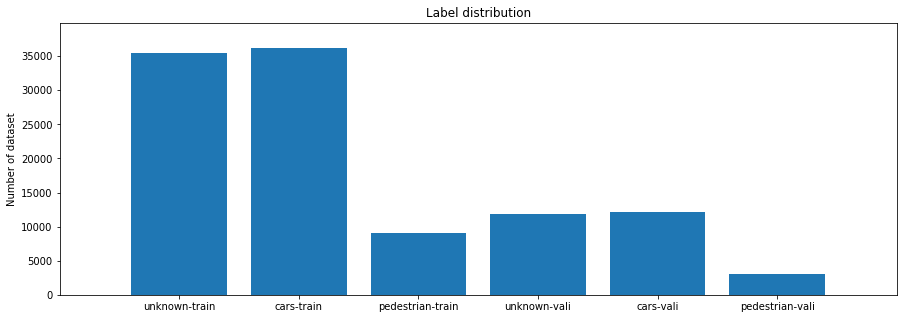

In [3]:
""" Load dataset"""

data = []
class_label = []
heading_label = []

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    class_label = f['class'][:]
    heading_label = f['heading'][:]
    return (data, class_label, heading_label)

data_train, class_label_train, heading_label_train = load_h5(data_train_path)
data_vali, class_label_vali, heading_label_vali = load_h5(data_vali_path)

data.append(data_train)
data.append(data_vali)
class_label.append(class_label_train)
class_label.append(class_label_vali)
heading_label.append(heading_label_train)
heading_label.append(heading_label_vali)

""" Data statistics """

label_list = [0,1,2]

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(class_label[i] == label_list[j]))

x_name=('unknown-train', 'cars-train','pedestrian-train',
        'unknown-vali', 'cars-vali', 'pedestrian-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [4]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 10

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5',))
p.start()
p.join()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-03 22:03:49.714966  

 Train one epoch   1 /  10


100%|██████████| 1615/1615 [09:39<00:00,  2.79it/s]


2018-12-03 22:13:30.194931  [Epoch 0] mean loss: 0.011399
2018-12-03 22:13:30.197077  [Epoch 0] heading rmse[deg]: 147.107654
2018-12-03 22:13:30.199025  [Epoch 0] class accuracy: 0.770402
2018-12-03 22:13:30.215946  [Epoch 0] avg class acc: 0.795778
2018-12-03 22:13:30.217748  [Epoch 0] indivisual [0] class recall: 0.708417
2018-12-03 22:13:30.219423  [Epoch 0] indivisual [0] class precision: 0.758754
2018-12-03 22:13:30.221168  [Epoch 0] indivisual [1] class recall: 0.805585
2018-12-03 22:13:30.223081  [Epoch 0] indivisual [1] class precision: 0.765290
2018-12-03 22:13:30.224919  [Epoch 0] indivisual [2] class recall: 0.873333
2018-12-03 22:13:30.226907  [Epoch 0] indivisual [2] class precision: 0.831922
2018-12-03 22:13:30.228612   Evaluation one (validation set) epoch   1 /  10


100%|██████████| 538/538 [00:45<00:00, 11.78it/s]


2018-12-03 22:14:16.318422  [Epoch 0] Validation mean loss: 0.009211
2018-12-03 22:14:16.320021  [Epoch 0] Validation heading rmse[deg]: 106.396026
2018-12-03 22:14:16.321475  [Epoch 0] Validation class accuracy: 0.832788
2018-12-03 22:14:16.322977  [Epoch 0] Validation avg class acc: 0.213410
2018-12-03 22:14:16.324804  [Epoch 0] Validation indivisual [0] class recall: 0.229685
2018-12-03 22:14:16.326466  [Epoch 0] Validation indivisual [0] class precision: 0.753937
2018-12-03 22:14:16.328205  [Epoch 0] Validation indivisual [1] class recall: 0.181865
2018-12-03 22:14:16.329878  [Epoch 0] Validation indivisual [1] class precision: 0.951098
2018-12-03 22:14:16.331577  [Epoch 0] Validation indivisual [2] class recall: 0.228679
2018-12-03 22:14:16.333231  [Epoch 0] Validation indivisual [2] class precision: 0.846083
2018-12-03 22:14:16.334904  

 Train one epoch   2 /  10


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-03 22:23:55.767410  [Epoch 1] mean loss: 0.004901
2018-12-03 22:23:55.769299  [Epoch 1] heading rmse[deg]: 105.446991
2018-12-03 22:23:55.770944  [Epoch 1] class accuracy: 0.911220
2018-12-03 22:23:55.772695  [Epoch 1] avg class acc: 0.918323
2018-12-03 22:23:55.774255  [Epoch 1] indivisual [0] class recall: 0.890810
2018-12-03 22:23:55.775902  [Epoch 1] indivisual [0] class precision: 0.906377
2018-12-03 22:23:55.777432  [Epoch 1] indivisual [1] class recall: 0.924049
2018-12-03 22:23:55.778970  [Epoch 1] indivisual [1] class precision: 0.923412
2018-12-03 22:23:55.780605  [Epoch 1] indivisual [2] class recall: 0.940111
2018-12-03 22:23:55.782387  [Epoch 1] indivisual [2] class precision: 0.882733
2018-12-03 22:23:55.784019   Evaluation one (validation set) epoch   2 /  10


100%|██████████| 538/538 [00:45<00:00, 11.75it/s]


2018-12-03 22:24:42.009175  [Epoch 1] Validation mean loss: 0.003617
2018-12-03 22:24:42.011048  [Epoch 1] Validation heading rmse[deg]: 104.693826
2018-12-03 22:24:42.012853  [Epoch 1] Validation class accuracy: 0.947249
2018-12-03 22:24:42.014648  [Epoch 1] Validation avg class acc: 0.232854
2018-12-03 22:24:42.016484  [Epoch 1] Validation indivisual [0] class recall: 0.241758
2018-12-03 22:24:42.018215  [Epoch 1] Validation indivisual [0] class precision: 0.916366
2018-12-03 22:24:42.019978  [Epoch 1] Validation indivisual [1] class recall: 0.235601
2018-12-03 22:24:42.021714  [Epoch 1] Validation indivisual [1] class precision: 0.994238
2018-12-03 22:24:42.023207  [Epoch 1] Validation indivisual [2] class recall: 0.221204
2018-12-03 22:24:42.024884  [Epoch 1] Validation indivisual [2] class precision: 0.895714
2018-12-03 22:24:42.026545  

 Train one epoch   3 /  10


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-03 22:34:21.662246  [Epoch 2] mean loss: 0.003103
2018-12-03 22:34:21.664169  [Epoch 2] heading rmse[deg]: 104.706929
2018-12-03 22:34:21.665954  [Epoch 2] class accuracy: 0.947591
2018-12-03 22:34:21.667803  [Epoch 2] avg class acc: 0.948351
2018-12-03 22:34:21.669551  [Epoch 2] indivisual [0] class recall: 0.933407
2018-12-03 22:34:21.671355  [Epoch 2] indivisual [0] class precision: 0.947060
2018-12-03 22:34:21.673042  [Epoch 2] indivisual [1] class recall: 0.960647
2018-12-03 22:34:21.674653  [Epoch 2] indivisual [1] class precision: 0.961921
2018-12-03 22:34:21.676270  [Epoch 2] indivisual [2] class recall: 0.951000
2018-12-03 22:34:21.677783  [Epoch 2] indivisual [2] class precision: 0.895293
2018-12-03 22:34:21.679357   Evaluation one (validation set) epoch   3 /  10


100%|██████████| 538/538 [00:45<00:00, 11.89it/s]


2018-12-03 22:35:07.358280  [Epoch 2] Validation mean loss: 0.002244
2018-12-03 22:35:07.360177  [Epoch 2] Validation heading rmse[deg]: 104.203926
2018-12-03 22:35:07.362006  [Epoch 2] Validation class accuracy: 0.975093
2018-12-03 22:35:07.363989  [Epoch 2] Validation avg class acc: 0.239507
2018-12-03 22:35:07.365653  [Epoch 2] Validation indivisual [0] class recall: 0.241847
2018-12-03 22:35:07.367671  [Epoch 2] Validation indivisual [0] class precision: 0.977116
2018-12-03 22:35:07.369807  [Epoch 2] Validation indivisual [1] class recall: 0.249535
2018-12-03 22:35:07.371730  [Epoch 2] Validation indivisual [1] class precision: 0.991289
2018-12-03 22:35:07.373580  [Epoch 2] Validation indivisual [2] class recall: 0.227140
2018-12-03 22:35:07.375301  [Epoch 2] Validation indivisual [2] class precision: 0.902019
2018-12-03 22:35:07.377198  

 Train one epoch   4 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-03 22:44:45.692463  [Epoch 3] mean loss: 0.002123
2018-12-03 22:44:45.694427  [Epoch 3] heading rmse[deg]: 104.489407
2018-12-03 22:44:45.696231  [Epoch 3] class accuracy: 0.965746
2018-12-03 22:44:45.698053  [Epoch 3] avg class acc: 0.965491
2018-12-03 22:44:45.699950  [Epoch 3] indivisual [0] class recall: 0.955766
2018-12-03 22:44:45.701864  [Epoch 3] indivisual [0] class precision: 0.966241
2018-12-03 22:44:45.703697  [Epoch 3] indivisual [1] class recall: 0.975715
2018-12-03 22:44:45.705415  [Epoch 3] indivisual [1] class precision: 0.980368
2018-12-03 22:44:45.707053  [Epoch 3] indivisual [2] class recall: 0.964992
2018-12-03 22:44:45.708722  [Epoch 3] indivisual [2] class precision: 0.908739
2018-12-03 22:44:45.710300   Evaluation one (validation set) epoch   4 /  10


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


2018-12-03 22:45:31.185292  [Epoch 3] Validation mean loss: 0.002456
2018-12-03 22:45:31.187122  [Epoch 3] Validation heading rmse[deg]: 105.155307
2018-12-03 22:45:31.188912  [Epoch 3] Validation class accuracy: 0.977249
2018-12-03 22:45:31.190675  [Epoch 3] Validation avg class acc: 0.238943
2018-12-03 22:45:31.192336  [Epoch 3] Validation indivisual [0] class recall: 0.245377
2018-12-03 22:45:31.194057  [Epoch 3] Validation indivisual [0] class precision: 0.972283
2018-12-03 22:45:31.195944  [Epoch 3] Validation indivisual [1] class recall: 0.248257
2018-12-03 22:45:31.197899  [Epoch 3] Validation indivisual [1] class precision: 0.989936
2018-12-03 22:45:31.199712  [Epoch 3] Validation indivisual [2] class recall: 0.223195
2018-12-03 22:45:31.201538  [Epoch 3] Validation indivisual [2] class precision: 0.943935
2018-12-03 22:45:31.203285  

 Train one epoch   5 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-03 22:55:09.314881  [Epoch 4] mean loss: 0.001756
2018-12-03 22:55:09.316976  [Epoch 4] heading rmse[deg]: 104.408343
2018-12-03 22:55:09.321850  [Epoch 4] class accuracy: 0.972000
2018-12-03 22:55:09.324872  [Epoch 4] avg class acc: 0.970998
2018-12-03 22:55:09.326815  [Epoch 4] indivisual [0] class recall: 0.964042
2018-12-03 22:55:09.328581  [Epoch 4] indivisual [0] class precision: 0.972228
2018-12-03 22:55:09.330177  [Epoch 4] indivisual [1] class recall: 0.980739
2018-12-03 22:55:09.331895  [Epoch 4] indivisual [1] class precision: 0.983018
2018-12-03 22:55:09.333657  [Epoch 4] indivisual [2] class recall: 0.968212
2018-12-03 22:55:09.335653  [Epoch 4] indivisual [2] class precision: 0.928678
2018-12-03 22:55:09.337327   Evaluation one (validation set) epoch   5 /  10


100%|██████████| 538/538 [00:45<00:00, 11.92it/s]


2018-12-03 22:55:54.912946  [Epoch 4] Validation mean loss: 0.002240
2018-12-03 22:55:54.915069  [Epoch 4] Validation heading rmse[deg]: 103.840658
2018-12-03 22:55:54.917004  [Epoch 4] Validation class accuracy: 0.973271
2018-12-03 22:55:54.919008  [Epoch 4] Validation avg class acc: 0.239346
2018-12-03 22:55:54.920713  [Epoch 4] Validation indivisual [0] class recall: 0.244182
2018-12-03 22:55:54.922577  [Epoch 4] Validation indivisual [0] class precision: 0.965970
2018-12-03 22:55:54.924377  [Epoch 4] Validation indivisual [1] class recall: 0.246075
2018-12-03 22:55:54.926120  [Epoch 4] Validation indivisual [1] class precision: 0.993818
2018-12-03 22:55:54.927958  [Epoch 4] Validation indivisual [2] class recall: 0.227781
2018-12-03 22:55:54.929842  [Epoch 4] Validation indivisual [2] class precision: 0.919865
2018-12-03 22:55:54.931537  

 Train one epoch   6 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-03 23:05:33.470678  [Epoch 5] mean loss: 0.001017
2018-12-03 23:05:33.472719  [Epoch 5] heading rmse[deg]: 104.066295
2018-12-03 23:05:33.474684  [Epoch 5] class accuracy: 0.985437
2018-12-03 23:05:33.476771  [Epoch 5] avg class acc: 0.983932
2018-12-03 23:05:33.478573  [Epoch 5] indivisual [0] class recall: 0.980911
2018-12-03 23:05:33.480476  [Epoch 5] indivisual [0] class precision: 0.986130
2018-12-03 23:05:33.482217  [Epoch 5] indivisual [1] class recall: 0.991334
2018-12-03 23:05:33.483880  [Epoch 5] indivisual [1] class precision: 0.992485
2018-12-03 23:05:33.485423  [Epoch 5] indivisual [2] class recall: 0.979551
2018-12-03 23:05:33.486909  [Epoch 5] indivisual [2] class precision: 0.955137
2018-12-03 23:05:33.488514   Evaluation one (validation set) epoch   6 /  10


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


2018-12-03 23:06:18.870800  [Epoch 5] Validation mean loss: 0.002096
2018-12-03 23:06:18.872661  [Epoch 5] Validation heading rmse[deg]: 103.820206
2018-12-03 23:06:18.874432  [Epoch 5] Validation class accuracy: 0.984572
2018-12-03 23:06:18.876406  [Epoch 5] Validation avg class acc: 0.240993
2018-12-03 23:06:18.878070  [Epoch 5] Validation indivisual [0] class recall: 0.247612
2018-12-03 23:06:18.879765  [Epoch 5] Validation indivisual [0] class precision: 0.978782
2018-12-03 23:06:18.881592  [Epoch 5] Validation indivisual [1] class recall: 0.249478
2018-12-03 23:06:18.883521  [Epoch 5] Validation indivisual [1] class precision: 0.993491
2018-12-03 23:06:18.885260  [Epoch 5] Validation indivisual [2] class recall: 0.225890
2018-12-03 23:06:18.886961  [Epoch 5] Validation indivisual [2] class precision: 0.970630
2018-12-03 23:06:18.888617  

 Train one epoch   7 /  10


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-03 23:15:58.235987  [Epoch 6] mean loss: 0.000870
2018-12-03 23:15:58.238029  [Epoch 6] heading rmse[deg]: 104.152940
2018-12-03 23:15:58.239956  [Epoch 6] class accuracy: 0.987616
2018-12-03 23:15:58.241818  [Epoch 6] avg class acc: 0.985465
2018-12-03 23:15:58.243604  [Epoch 6] indivisual [0] class recall: 0.984598
2018-12-03 23:15:58.245474  [Epoch 6] indivisual [0] class precision: 0.987267
2018-12-03 23:15:58.247112  [Epoch 6] indivisual [1] class recall: 0.992687
2018-12-03 23:15:58.248683  [Epoch 6] indivisual [1] class precision: 0.993537
2018-12-03 23:15:58.250469  [Epoch 6] indivisual [2] class recall: 0.979109
2018-12-03 23:15:58.252203  [Epoch 6] indivisual [2] class precision: 0.965483
2018-12-03 23:15:58.254015   Evaluation one (validation set) epoch   7 /  10


100%|██████████| 538/538 [00:45<00:00, 11.93it/s]


2018-12-03 23:16:43.785680  [Epoch 6] Validation mean loss: 0.002108
2018-12-03 23:16:43.787525  [Epoch 6] Validation heading rmse[deg]: 103.932513
2018-12-03 23:16:43.789331  [Epoch 6] Validation class accuracy: 0.983717
2018-12-03 23:16:43.791189  [Epoch 6] Validation avg class acc: 0.241486
2018-12-03 23:16:43.792905  [Epoch 6] Validation indivisual [0] class recall: 0.245900
2018-12-03 23:16:43.794573  [Epoch 6] Validation indivisual [0] class precision: 0.984350
2018-12-03 23:16:43.796420  [Epoch 6] Validation indivisual [1] class recall: 0.250021
2018-12-03 23:16:43.798088  [Epoch 6] Validation indivisual [1] class precision: 0.988224
2018-12-03 23:16:43.799803  [Epoch 6] Validation indivisual [2] class recall: 0.228538
2018-12-03 23:16:43.801458  [Epoch 6] Validation indivisual [2] class precision: 0.961768
2018-12-03 23:16:43.803020  

 Train one epoch   8 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-03 23:26:22.509080  [Epoch 7] mean loss: 0.000669
2018-12-03 23:26:22.511177  [Epoch 7] heading rmse[deg]: 103.995613
2018-12-03 23:26:22.513434  [Epoch 7] class accuracy: 0.991418
2018-12-03 23:26:22.515488  [Epoch 7] avg class acc: 0.989909
2018-12-03 23:26:22.517224  [Epoch 7] indivisual [0] class recall: 0.989694
2018-12-03 23:26:22.519506  [Epoch 7] indivisual [0] class precision: 0.990810
2018-12-03 23:26:22.521437  [Epoch 7] indivisual [1] class recall: 0.994591
2018-12-03 23:26:22.523182  [Epoch 7] indivisual [1] class precision: 0.995580
2018-12-03 23:26:22.524843  [Epoch 7] indivisual [2] class recall: 0.985443
2018-12-03 23:26:22.526500  [Epoch 7] indivisual [2] class precision: 0.977190
2018-12-03 23:26:22.528213   Evaluation one (validation set) epoch   8 /  10


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


2018-12-03 23:27:08.015150  [Epoch 7] Validation mean loss: 0.001972
2018-12-03 23:27:08.017175  [Epoch 7] Validation heading rmse[deg]: 104.665479
2018-12-03 23:27:08.018922  [Epoch 7] Validation class accuracy: 0.986245
2018-12-03 23:27:08.020825  [Epoch 7] Validation avg class acc: 0.241340
2018-12-03 23:27:08.022499  [Epoch 7] Validation indivisual [0] class recall: 0.247929
2018-12-03 23:27:08.024414  [Epoch 7] Validation indivisual [0] class precision: 0.982414
2018-12-03 23:27:08.026355  [Epoch 7] Validation indivisual [1] class recall: 0.250062
2018-12-03 23:27:08.028209  [Epoch 7] Validation indivisual [1] class precision: 0.991714
2018-12-03 23:27:08.029905  [Epoch 7] Validation indivisual [2] class recall: 0.226030
2018-12-03 23:27:08.031591  [Epoch 7] Validation indivisual [2] class precision: 0.978700
2018-12-03 23:27:08.033516  

 Train one epoch   9 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-03 23:36:46.413469  [Epoch 8] mean loss: 0.000498
2018-12-03 23:36:46.415376  [Epoch 8] heading rmse[deg]: 103.956070
2018-12-03 23:36:46.417280  [Epoch 8] class accuracy: 0.995059
2018-12-03 23:36:46.419332  [Epoch 8] avg class acc: 0.993925
2018-12-03 23:36:46.421471  [Epoch 8] indivisual [0] class recall: 0.994228
2018-12-03 23:36:46.423319  [Epoch 8] indivisual [0] class precision: 0.994536
2018-12-03 23:36:46.425099  [Epoch 8] indivisual [1] class recall: 0.996992
2018-12-03 23:36:46.426775  [Epoch 8] indivisual [1] class precision: 0.997350
2018-12-03 23:36:46.428536  [Epoch 8] indivisual [2] class recall: 0.990556
2018-12-03 23:36:46.430168  [Epoch 8] indivisual [2] class precision: 0.987921
2018-12-03 23:36:46.431858   Evaluation one (validation set) epoch   9 /  10


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


2018-12-03 23:37:31.900783  [Epoch 8] Validation mean loss: 0.002431
2018-12-03 23:37:31.902780  [Epoch 8] Validation heading rmse[deg]: 103.805798
2018-12-03 23:37:31.904448  [Epoch 8] Validation class accuracy: 0.984498
2018-12-03 23:37:31.906203  [Epoch 8] Validation avg class acc: 0.241123
2018-12-03 23:37:31.907949  [Epoch 8] Validation indivisual [0] class recall: 0.246544
2018-12-03 23:37:31.909565  [Epoch 8] Validation indivisual [0] class precision: 0.985636
2018-12-03 23:37:31.911329  [Epoch 8] Validation indivisual [1] class recall: 0.250331
2018-12-03 23:37:31.913233  [Epoch 8] Validation indivisual [1] class precision: 0.987031
2018-12-03 23:37:31.914919  [Epoch 8] Validation indivisual [2] class recall: 0.226492
2018-12-03 23:37:31.916679  [Epoch 8] Validation indivisual [2] class precision: 0.968627
2018-12-03 23:37:31.918367  

 Train one epoch  10 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-03 23:47:10.841935  [Epoch 9] mean loss: 0.000468
2018-12-03 23:47:10.843955  [Epoch 9] heading rmse[deg]: 103.959266
2018-12-03 23:47:10.845780  [Epoch 9] class accuracy: 0.995282
2018-12-03 23:47:10.847814  [Epoch 9] avg class acc: 0.994206
2018-12-03 23:47:10.850076  [Epoch 9] indivisual [0] class recall: 0.994847
2018-12-03 23:47:10.851915  [Epoch 9] indivisual [0] class precision: 0.994455
2018-12-03 23:47:10.853715  [Epoch 9] indivisual [1] class recall: 0.996771
2018-12-03 23:47:10.855428  [Epoch 9] indivisual [1] class precision: 0.997459
2018-12-03 23:47:10.857287  [Epoch 9] indivisual [2] class recall: 0.990999
2018-12-03 23:47:10.859025  [Epoch 9] indivisual [2] class precision: 0.989789
2018-12-03 23:47:10.860810   Evaluation one (validation set) epoch  10 /  10


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


2018-12-03 23:47:56.281624  [Epoch 9] Validation mean loss: 0.002104
2018-12-03 23:47:56.283510  [Epoch 9] Validation heading rmse[deg]: 103.889328
2018-12-03 23:47:56.285236  [Epoch 9] Validation class accuracy: 0.986952
2018-12-03 23:47:56.287070  [Epoch 9] Validation avg class acc: 0.242281
2018-12-03 23:47:56.288806  [Epoch 9] Validation indivisual [0] class recall: 0.247210
2018-12-03 23:47:56.290429  [Epoch 9] Validation indivisual [0] class precision: 0.987005
2018-12-03 23:47:56.293426  [Epoch 9] Validation indivisual [1] class recall: 0.250352
2018-12-03 23:47:56.295318  [Epoch 9] Validation indivisual [1] class precision: 0.990830
2018-12-03 23:47:56.297235  [Epoch 9] Validation indivisual [2] class recall: 0.229281
2018-12-03 23:47:56.298992  [Epoch 9] Validation indivisual [2] class precision: 0.970018
2018-12-03 23:47:57.212019  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181203/model_out5/model.ckpt


In [5]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 20

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=0.2)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_1',))
p.start()
p.join()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-03 23:56:46.939556  

 Train one epoch   1 /  20


100%|██████████| 1615/1615 [09:43<00:00,  2.77it/s]


2018-12-04 00:06:31.117574  [Epoch 0] mean loss: 0.012465
2018-12-04 00:06:31.119302  [Epoch 0] heading rmse[deg]: 149.063311
2018-12-04 00:06:31.120755  [Epoch 0] class accuracy: 0.747480
2018-12-04 00:06:31.122302  [Epoch 0] avg class acc: 0.775305
2018-12-04 00:06:31.123772  [Epoch 0] indivisual [0] class recall: 0.675781
2018-12-04 00:06:31.125255  [Epoch 0] indivisual [0] class precision: 0.736233
2018-12-04 00:06:31.126639  [Epoch 0] indivisual [1] class recall: 0.789690
2018-12-04 00:06:31.128123  [Epoch 0] indivisual [1] class precision: 0.738344
2018-12-04 00:06:31.129521  [Epoch 0] indivisual [2] class recall: 0.860444
2018-12-04 00:06:31.130892  [Epoch 0] indivisual [2] class precision: 0.824181
2018-12-04 00:06:31.132305   Evaluation one (validation set) epoch   1 /  20


100%|██████████| 538/538 [00:45<00:00, 11.83it/s]


2018-12-04 00:07:16.993339  [Epoch 0] Validation mean loss: 0.004854
2018-12-04 00:07:16.995367  [Epoch 0] Validation heading rmse[deg]: 105.124950
2018-12-04 00:07:16.997357  [Epoch 0] Validation class accuracy: 0.931896
2018-12-04 00:07:16.999212  [Epoch 0] Validation avg class acc: 0.231221
2018-12-04 00:07:17.001068  [Epoch 0] Validation indivisual [0] class recall: 0.240231
2018-12-04 00:07:17.002867  [Epoch 0] Validation indivisual [0] class precision: 0.892369
2018-12-04 00:07:17.004587  [Epoch 0] Validation indivisual [1] class recall: 0.227337
2018-12-04 00:07:17.006207  [Epoch 0] Validation indivisual [1] class precision: 0.986003
2018-12-04 00:07:17.007888  [Epoch 0] Validation indivisual [2] class recall: 0.226094
2018-12-04 00:07:17.009618  [Epoch 0] Validation indivisual [2] class precision: 0.898906
2018-12-04 00:07:17.011299  

 Train one epoch   2 /  20


100%|██████████| 1615/1615 [09:40<00:00,  2.78it/s]


2018-12-04 00:16:58.274600  [Epoch 1] mean loss: 0.005925
2018-12-04 00:16:58.276807  [Epoch 1] heading rmse[deg]: 105.150640
2018-12-04 00:16:58.278669  [Epoch 1] class accuracy: 0.891802
2018-12-04 00:16:58.280594  [Epoch 1] avg class acc: 0.900821
2018-12-04 00:16:58.282365  [Epoch 1] indivisual [0] class recall: 0.863132
2018-12-04 00:16:58.284153  [Epoch 1] indivisual [0] class precision: 0.888576
2018-12-04 00:16:58.285889  [Epoch 1] indivisual [1] class recall: 0.910774
2018-12-04 00:16:58.287616  [Epoch 1] indivisual [1] class precision: 0.899651
2018-12-04 00:16:58.289237  [Epoch 1] indivisual [2] class recall: 0.928556
2018-12-04 00:16:58.290732  [Epoch 1] indivisual [2] class precision: 0.873341
2018-12-04 00:16:58.292319   Evaluation one (validation set) epoch   2 /  20


100%|██████████| 538/538 [00:45<00:00, 11.89it/s]


2018-12-04 00:17:43.993407  [Epoch 1] Validation mean loss: 0.003100
2018-12-04 00:17:43.995350  [Epoch 1] Validation heading rmse[deg]: 104.091046
2018-12-04 00:17:43.997194  [Epoch 1] Validation class accuracy: 0.965353
2018-12-04 00:17:43.998911  [Epoch 1] Validation avg class acc: 0.237199
2018-12-04 00:17:44.000461  [Epoch 1] Validation indivisual [0] class recall: 0.242392
2018-12-04 00:17:44.002066  [Epoch 1] Validation indivisual [0] class precision: 0.953129
2018-12-04 00:17:44.003632  [Epoch 1] Validation indivisual [1] class recall: 0.244083
2018-12-04 00:17:44.005406  [Epoch 1] Validation indivisual [1] class precision: 0.990929
2018-12-04 00:17:44.007344  [Epoch 1] Validation indivisual [2] class recall: 0.225121
2018-12-04 00:17:44.009142  [Epoch 1] Validation indivisual [2] class precision: 0.912192
2018-12-04 00:17:44.010914  

 Train one epoch   3 /  20


100%|██████████| 1615/1615 [09:40<00:00,  2.78it/s]


2018-12-04 00:27:25.427066  [Epoch 2] mean loss: 0.003915
2018-12-04 00:27:25.428859  [Epoch 2] heading rmse[deg]: 104.526460
2018-12-04 00:27:25.430638  [Epoch 2] class accuracy: 0.931269
2018-12-04 00:27:25.432513  [Epoch 2] avg class acc: 0.934841
2018-12-04 00:27:25.434386  [Epoch 2] indivisual [0] class recall: 0.909106
2018-12-04 00:27:25.436253  [Epoch 2] indivisual [0] class precision: 0.933526
2018-12-04 00:27:25.438104  [Epoch 2] indivisual [1] class recall: 0.949305
2018-12-04 00:27:25.440038  [Epoch 2] indivisual [1] class precision: 0.940043
2018-12-04 00:27:25.442023  [Epoch 2] indivisual [2] class recall: 0.946111
2018-12-04 00:27:25.443711  [Epoch 2] indivisual [2] class precision: 0.889574
2018-12-04 00:27:25.445488   Evaluation one (validation set) epoch   3 /  20


100%|██████████| 538/538 [00:45<00:00, 11.90it/s]


2018-12-04 00:28:11.113080  [Epoch 2] Validation mean loss: 0.002403
2018-12-04 00:28:11.114960  [Epoch 2] Validation heading rmse[deg]: 103.826852
2018-12-04 00:28:11.116749  [Epoch 2] Validation class accuracy: 0.977621
2018-12-04 00:28:11.118506  [Epoch 2] Validation avg class acc: 0.240651
2018-12-04 00:28:11.120398  [Epoch 2] Validation indivisual [0] class recall: 0.242693
2018-12-04 00:28:11.122330  [Epoch 2] Validation indivisual [0] class precision: 0.985073
2018-12-04 00:28:11.124166  [Epoch 2] Validation indivisual [1] class recall: 0.249452
2018-12-04 00:28:11.125926  [Epoch 2] Validation indivisual [1] class precision: 0.986905
2018-12-04 00:28:11.127709  [Epoch 2] Validation indivisual [2] class recall: 0.229807
2018-12-04 00:28:11.129459  [Epoch 2] Validation indivisual [2] class precision: 0.911405
2018-12-04 00:28:11.131117  

 Train one epoch   4 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 00:37:50.931524  [Epoch 3] mean loss: 0.002700
2018-12-04 00:37:50.933517  [Epoch 3] heading rmse[deg]: 104.465866
2018-12-04 00:37:50.935271  [Epoch 3] class accuracy: 0.957536
2018-12-04 00:37:50.937199  [Epoch 3] avg class acc: 0.959125
2018-12-04 00:37:50.939228  [Epoch 3] indivisual [0] class recall: 0.944870
2018-12-04 00:37:50.941173  [Epoch 3] indivisual [0] class precision: 0.958335
2018-12-04 00:37:50.942721  [Epoch 3] indivisual [1] class recall: 0.968291
2018-12-04 00:37:50.944494  [Epoch 3] indivisual [1] class precision: 0.968425
2018-12-04 00:37:50.946181  [Epoch 3] indivisual [2] class recall: 0.964214
2018-12-04 00:37:50.947955  [Epoch 3] indivisual [2] class precision: 0.913071
2018-12-04 00:37:50.949630   Evaluation one (validation set) epoch   4 /  20


100%|██████████| 538/538 [00:45<00:00, 11.91it/s]


2018-12-04 00:38:36.569614  [Epoch 3] Validation mean loss: 0.002749
2018-12-04 00:38:36.571307  [Epoch 3] Validation heading rmse[deg]: 104.699792
2018-12-04 00:38:36.572986  [Epoch 3] Validation class accuracy: 0.974349
2018-12-04 00:38:36.574698  [Epoch 3] Validation avg class acc: 0.237256
2018-12-04 00:38:36.576546  [Epoch 3] Validation indivisual [0] class recall: 0.245441
2018-12-04 00:38:36.578231  [Epoch 3] Validation indivisual [0] class precision: 0.965179
2018-12-04 00:38:36.580124  [Epoch 3] Validation indivisual [1] class recall: 0.247719
2018-12-04 00:38:36.582007  [Epoch 3] Validation indivisual [1] class precision: 0.990569
2018-12-04 00:38:36.583728  [Epoch 3] Validation indivisual [2] class recall: 0.218609
2018-12-04 00:38:36.585472  [Epoch 3] Validation indivisual [2] class precision: 0.943505
2018-12-04 00:38:36.587160  

 Train one epoch   5 /  20


100%|██████████| 1615/1615 [09:40<00:00,  2.78it/s]


2018-12-04 00:48:18.381281  [Epoch 4] mean loss: 0.002007
2018-12-04 00:48:18.383117  [Epoch 4] heading rmse[deg]: 104.416842
2018-12-04 00:48:18.386053  [Epoch 4] class accuracy: 0.970613
2018-12-04 00:48:18.387859  [Epoch 4] avg class acc: 0.970151
2018-12-04 00:48:18.389403  [Epoch 4] indivisual [0] class recall: 0.962297
2018-12-04 00:48:18.390926  [Epoch 4] indivisual [0] class precision: 0.970853
2018-12-04 00:48:18.392437  [Epoch 4] indivisual [1] class recall: 0.979166
2018-12-04 00:48:18.393902  [Epoch 4] indivisual [1] class precision: 0.981658
2018-12-04 00:48:18.395499  [Epoch 4] indivisual [2] class recall: 0.968990
2018-12-04 00:48:18.397003  [Epoch 4] indivisual [2] class precision: 0.927250
2018-12-04 00:48:18.398516   Evaluation one (validation set) epoch   5 /  20


100%|██████████| 538/538 [00:45<00:00, 11.92it/s]


2018-12-04 00:49:03.973772  [Epoch 4] Validation mean loss: 0.002380
2018-12-04 00:49:03.975535  [Epoch 4] Validation heading rmse[deg]: 103.880617
2018-12-04 00:49:03.977400  [Epoch 4] Validation class accuracy: 0.977435
2018-12-04 00:49:03.979158  [Epoch 4] Validation avg class acc: 0.239311
2018-12-04 00:49:03.980842  [Epoch 4] Validation indivisual [0] class recall: 0.245345
2018-12-04 00:49:03.982667  [Epoch 4] Validation indivisual [0] class precision: 0.975216
2018-12-04 00:49:03.984709  [Epoch 4] Validation indivisual [1] class recall: 0.248061
2018-12-04 00:49:03.986448  [Epoch 4] Validation indivisual [1] class precision: 0.990092
2018-12-04 00:49:03.988240  [Epoch 4] Validation indivisual [2] class recall: 0.224529
2018-12-04 00:49:03.989937  [Epoch 4] Validation indivisual [2] class precision: 0.933449
2018-12-04 00:49:03.991713  

 Train one epoch   6 /  20


100%|██████████| 1615/1615 [09:41<00:00,  2.78it/s]


2018-12-04 00:58:46.171988  [Epoch 5] mean loss: 0.001280
2018-12-04 00:58:46.173730  [Epoch 5] heading rmse[deg]: 104.056772
2018-12-04 00:58:46.175369  [Epoch 5] class accuracy: 0.983368
2018-12-04 00:58:46.177043  [Epoch 5] avg class acc: 0.982020
2018-12-04 00:58:46.178584  [Epoch 5] indivisual [0] class recall: 0.978827
2018-12-04 00:58:46.180170  [Epoch 5] indivisual [0] class precision: 0.983340
2018-12-04 00:58:46.182086  [Epoch 5] indivisual [1] class recall: 0.989127
2018-12-04 00:58:46.184128  [Epoch 5] indivisual [1] class precision: 0.990411
2018-12-04 00:58:46.185981  [Epoch 5] indivisual [2] class recall: 0.978106
2018-12-04 00:58:46.187802  [Epoch 5] indivisual [2] class precision: 0.955799
2018-12-04 00:58:46.189499   Evaluation one (validation set) epoch   6 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 00:59:31.656718  [Epoch 5] Validation mean loss: 0.002491
2018-12-04 00:59:31.658549  [Epoch 5] Validation heading rmse[deg]: 103.800788
2018-12-04 00:59:31.660255  [Epoch 5] Validation class accuracy: 0.978959
2018-12-04 00:59:31.661908  [Epoch 5] Validation avg class acc: 0.239895
2018-12-04 00:59:31.663737  [Epoch 5] Validation indivisual [0] class recall: 0.245541
2018-12-04 00:59:31.665669  [Epoch 5] Validation indivisual [0] class precision: 0.972220
2018-12-04 00:59:31.667515  [Epoch 5] Validation indivisual [1] class recall: 0.248422
2018-12-04 00:59:31.669249  [Epoch 5] Validation indivisual [1] class precision: 0.995605
2018-12-04 00:59:31.670856  [Epoch 5] Validation indivisual [2] class recall: 0.225723
2018-12-04 00:59:31.672537  [Epoch 5] Validation indivisual [2] class precision: 0.937349
2018-12-04 00:59:31.674158  

 Train one epoch   7 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 01:09:11.003495  [Epoch 6] mean loss: 0.001149
2018-12-04 01:09:11.005337  [Epoch 6] heading rmse[deg]: 104.165578
2018-12-04 01:09:11.007081  [Epoch 6] class accuracy: 0.986192
2018-12-04 01:09:11.009053  [Epoch 6] avg class acc: 0.984956
2018-12-04 01:09:11.010713  [Epoch 6] indivisual [0] class recall: 0.983444
2018-12-04 01:09:11.012356  [Epoch 6] indivisual [0] class precision: 0.985247
2018-12-04 01:09:11.013973  [Epoch 6] indivisual [1] class recall: 0.990093
2018-12-04 01:09:11.015680  [Epoch 6] indivisual [1] class precision: 0.991982
2018-12-04 01:09:11.017278  [Epoch 6] indivisual [2] class recall: 0.981331
2018-12-04 01:09:11.018822  [Epoch 6] indivisual [2] class precision: 0.966933
2018-12-04 01:09:11.020425   Evaluation one (validation set) epoch   7 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 01:09:56.544599  [Epoch 6] Validation mean loss: 0.002540
2018-12-04 01:09:56.546477  [Epoch 6] Validation heading rmse[deg]: 104.004489
2018-12-04 01:09:56.548383  [Epoch 6] Validation class accuracy: 0.979888
2018-12-04 01:09:56.550301  [Epoch 6] Validation avg class acc: 0.240301
2018-12-04 01:09:56.552149  [Epoch 6] Validation indivisual [0] class recall: 0.246640
2018-12-04 01:09:56.554085  [Epoch 6] Validation indivisual [0] class precision: 0.973638
2018-12-04 01:09:56.556014  [Epoch 6] Validation indivisual [1] class recall: 0.247641
2018-12-04 01:09:56.557755  [Epoch 6] Validation indivisual [1] class precision: 0.991550
2018-12-04 01:09:56.559554  [Epoch 6] Validation indivisual [2] class recall: 0.226621
2018-12-04 01:09:56.561240  [Epoch 6] Validation indivisual [2] class precision: 0.956721
2018-12-04 01:09:56.562857  

 Train one epoch   8 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 01:19:35.314929  [Epoch 7] mean loss: 0.000862
2018-12-04 01:19:35.316915  [Epoch 7] heading rmse[deg]: 103.988421
2018-12-04 01:19:35.318637  [Epoch 7] class accuracy: 0.990861
2018-12-04 01:19:35.320516  [Epoch 7] avg class acc: 0.988907
2018-12-04 01:19:35.322269  [Epoch 7] indivisual [0] class recall: 0.989160
2018-12-04 01:19:35.324250  [Epoch 7] indivisual [0] class precision: 0.990079
2018-12-04 01:19:35.326244  [Epoch 7] indivisual [1] class recall: 0.994453
2018-12-04 01:19:35.327990  [Epoch 7] indivisual [1] class precision: 0.995002
2018-12-04 01:19:35.329722  [Epoch 7] indivisual [2] class recall: 0.983109
2018-12-04 01:19:35.331343  [Epoch 7] indivisual [2] class precision: 0.977353
2018-12-04 01:19:35.333053   Evaluation one (validation set) epoch   8 /  20


100%|██████████| 538/538 [00:44<00:00, 11.97it/s]


2018-12-04 01:20:20.739774  [Epoch 7] Validation mean loss: 0.001946
2018-12-04 01:20:20.741732  [Epoch 7] Validation heading rmse[deg]: 104.597921
2018-12-04 01:20:20.743524  [Epoch 7] Validation class accuracy: 0.987546
2018-12-04 01:20:20.745256  [Epoch 7] Validation avg class acc: 0.242958
2018-12-04 01:20:20.747089  [Epoch 7] Validation indivisual [0] class recall: 0.247527
2018-12-04 01:20:20.749119  [Epoch 7] Validation indivisual [0] class precision: 0.987771
2018-12-04 01:20:20.750846  [Epoch 7] Validation indivisual [1] class recall: 0.249814
2018-12-04 01:20:20.752603  [Epoch 7] Validation indivisual [1] class precision: 0.990892
2018-12-04 01:20:20.754233  [Epoch 7] Validation indivisual [2] class recall: 0.231532
2018-12-04 01:20:20.755931  [Epoch 7] Validation indivisual [2] class precision: 0.972339
2018-12-04 01:20:20.757584  

 Train one epoch   9 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 01:29:59.323729  [Epoch 8] mean loss: 0.000857
2018-12-04 01:29:59.325603  [Epoch 8] heading rmse[deg]: 103.949283
2018-12-04 01:29:59.327391  [Epoch 8] class accuracy: 0.991641
2018-12-04 01:29:59.329268  [Epoch 8] avg class acc: 0.990581
2018-12-04 01:29:59.330938  [Epoch 8] indivisual [0] class recall: 0.990426
2018-12-04 01:29:59.332646  [Epoch 8] indivisual [0] class precision: 0.990677
2018-12-04 01:29:59.334604  [Epoch 8] indivisual [1] class recall: 0.993873
2018-12-04 01:29:59.336682  [Epoch 8] indivisual [1] class precision: 0.994615
2018-12-04 01:29:59.338419  [Epoch 8] indivisual [2] class recall: 0.987444
2018-12-04 01:29:59.340137  [Epoch 8] indivisual [2] class precision: 0.983510
2018-12-04 01:29:59.341819   Evaluation one (validation set) epoch   9 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 01:30:44.847495  [Epoch 8] Validation mean loss: 0.002146
2018-12-04 01:30:44.849403  [Epoch 8] Validation heading rmse[deg]: 103.879990
2018-12-04 01:30:44.851062  [Epoch 8] Validation class accuracy: 0.986022
2018-12-04 01:30:44.852915  [Epoch 8] Validation avg class acc: 0.242516
2018-12-04 01:30:44.854584  [Epoch 8] Validation indivisual [0] class recall: 0.247052
2018-12-04 01:30:44.856317  [Epoch 8] Validation indivisual [0] class precision: 0.986497
2018-12-04 01:30:44.857954  [Epoch 8] Validation indivisual [1] class recall: 0.249586
2018-12-04 01:30:44.859609  [Epoch 8] Validation indivisual [1] class precision: 0.991209
2018-12-04 01:30:44.861254  [Epoch 8] Validation indivisual [2] class recall: 0.230910
2018-12-04 01:30:44.862817  [Epoch 8] Validation indivisual [2] class precision: 0.962140
2018-12-04 01:30:44.864603  

 Train one epoch  10 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 01:40:23.600299  [Epoch 9] mean loss: 0.000693
2018-12-04 01:40:23.602249  [Epoch 9] heading rmse[deg]: 103.977375
2018-12-04 01:40:23.604066  [Epoch 9] class accuracy: 0.994105
2018-12-04 01:40:23.605996  [Epoch 9] avg class acc: 0.993321
2018-12-04 01:40:23.607667  [Epoch 9] indivisual [0] class recall: 0.993214
2018-12-04 01:40:23.609334  [Epoch 9] indivisual [0] class precision: 0.993438
2018-12-04 01:40:23.610885  [Epoch 9] indivisual [1] class recall: 0.995750
2018-12-04 01:40:23.612535  [Epoch 9] indivisual [1] class precision: 0.996245
2018-12-04 01:40:23.614463  [Epoch 9] indivisual [2] class recall: 0.990999
2018-12-04 01:40:23.616565  [Epoch 9] indivisual [2] class precision: 0.988144
2018-12-04 01:40:23.618341   Evaluation one (validation set) epoch  10 /  20


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


2018-12-04 01:41:09.128539  [Epoch 9] Validation mean loss: 0.002120
2018-12-04 01:41:09.130433  [Epoch 9] Validation heading rmse[deg]: 103.867211
2018-12-04 01:41:09.132201  [Epoch 9] Validation class accuracy: 0.985167
2018-12-04 01:41:09.134052  [Epoch 9] Validation avg class acc: 0.241780
2018-12-04 01:41:09.135861  [Epoch 9] Validation indivisual [0] class recall: 0.246766
2018-12-04 01:41:09.137535  [Epoch 9] Validation indivisual [0] class precision: 0.986315
2018-12-04 01:41:09.139432  [Epoch 9] Validation indivisual [1] class recall: 0.249959
2018-12-04 01:41:09.141291  [Epoch 9] Validation indivisual [1] class precision: 0.990248
2018-12-04 01:41:09.142933  [Epoch 9] Validation indivisual [2] class recall: 0.228614
2018-12-04 01:41:09.144649  [Epoch 9] Validation indivisual [2] class precision: 0.958741
2018-12-04 01:41:10.054538  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181203/model_out5_1/model.ckpt
2018-12-04 01:41:1

100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-04 01:50:48.843257  [Epoch 10] mean loss: 0.000604
2018-12-04 01:50:48.844990  [Epoch 10] heading rmse[deg]: 103.896439
2018-12-04 01:50:48.847017  [Epoch 10] class accuracy: 0.995889
2018-12-04 01:50:48.849248  [Epoch 10] avg class acc: 0.995245
2018-12-04 01:50:48.850912  [Epoch 10] indivisual [0] class recall: 0.995439
2018-12-04 01:50:48.852684  [Epoch 10] indivisual [0] class precision: 0.995243
2018-12-04 01:50:48.854374  [Epoch 10] indivisual [1] class recall: 0.996964
2018-12-04 01:50:48.856061  [Epoch 10] indivisual [1] class precision: 0.997350
2018-12-04 01:50:48.857637  [Epoch 10] indivisual [2] class recall: 0.993333
2018-12-04 01:50:48.859260  [Epoch 10] indivisual [2] class precision: 0.992561
2018-12-04 01:50:48.860871   Evaluation one (validation set) epoch  11 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 01:51:34.370456  [Epoch 10] Validation mean loss: 0.002209
2018-12-04 01:51:34.372215  [Epoch 10] Validation heading rmse[deg]: 103.817178
2018-12-04 01:51:34.373923  [Epoch 10] Validation class accuracy: 0.987509
2018-12-04 01:51:34.375668  [Epoch 10] Validation avg class acc: 0.243297
2018-12-04 01:51:34.377247  [Epoch 10] Validation indivisual [0] class recall: 0.246883
2018-12-04 01:51:34.379131  [Epoch 10] Validation indivisual [0] class precision: 0.991344
2018-12-04 01:51:34.381043  [Epoch 10] Validation indivisual [1] class recall: 0.250078
2018-12-04 01:51:34.382726  [Epoch 10] Validation indivisual [1] class precision: 0.988470
2018-12-04 01:51:34.384405  [Epoch 10] Validation indivisual [2] class recall: 0.232930
2018-12-04 01:51:34.386059  [Epoch 10] Validation indivisual [2] class precision: 0.967787
2018-12-04 01:51:34.387784  

 Train one epoch  12 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-04 02:01:13.333821  [Epoch 11] mean loss: 0.000542
2018-12-04 02:01:13.335631  [Epoch 11] heading rmse[deg]: 103.884182
2018-12-04 02:01:13.337344  [Epoch 11] class accuracy: 0.996780
2018-12-04 02:01:13.339063  [Epoch 11] avg class acc: 0.996193
2018-12-04 02:01:13.340686  [Epoch 11] indivisual [0] class recall: 0.996565
2018-12-04 02:01:13.342243  [Epoch 11] indivisual [0] class precision: 0.996116
2018-12-04 02:01:13.343981  [Epoch 11] indivisual [1] class recall: 0.997572
2018-12-04 02:01:13.345612  [Epoch 11] indivisual [1] class precision: 0.997930
2018-12-04 02:01:13.347167  [Epoch 11] indivisual [2] class recall: 0.994443
2018-12-04 02:01:13.349062  [Epoch 11] indivisual [2] class precision: 0.994775
2018-12-04 02:01:13.351092   Evaluation one (validation set) epoch  12 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 02:01:58.850689  [Epoch 11] Validation mean loss: 0.002339
2018-12-04 02:01:58.852696  [Epoch 11] Validation heading rmse[deg]: 103.830065
2018-12-04 02:01:58.854479  [Epoch 11] Validation class accuracy: 0.986394
2018-12-04 02:01:58.856351  [Epoch 11] Validation avg class acc: 0.242381
2018-12-04 02:01:58.858044  [Epoch 11] Validation indivisual [0] class recall: 0.247099
2018-12-04 02:01:58.859704  [Epoch 11] Validation indivisual [0] class precision: 0.988000
2018-12-04 02:01:58.861602  [Epoch 11] Validation indivisual [1] class recall: 0.249948
2018-12-04 02:01:58.863498  [Epoch 11] Validation indivisual [1] class precision: 0.989113
2018-12-04 02:01:58.865246  [Epoch 11] Validation indivisual [2] class recall: 0.230096
2018-12-04 02:01:58.866946  [Epoch 11] Validation indivisual [2] class precision: 0.968081
2018-12-04 02:01:58.868601  

 Train one epoch  13 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 02:11:37.881317  [Epoch 12] mean loss: 0.000499
2018-12-04 02:11:37.883070  [Epoch 12] heading rmse[deg]: 103.850279
2018-12-04 02:11:37.884812  [Epoch 12] class accuracy: 0.997598
2018-12-04 02:11:37.886509  [Epoch 12] avg class acc: 0.997140
2018-12-04 02:11:37.888240  [Epoch 12] indivisual [0] class recall: 0.997382
2018-12-04 02:11:37.889954  [Epoch 12] indivisual [0] class precision: 0.997157
2018-12-04 02:11:37.891594  [Epoch 12] indivisual [1] class recall: 0.998261
2018-12-04 02:11:37.893153  [Epoch 12] indivisual [1] class precision: 0.998564
2018-12-04 02:11:37.895065  [Epoch 12] indivisual [2] class recall: 0.995776
2018-12-04 02:11:37.897127  [Epoch 12] indivisual [2] class precision: 0.995444
2018-12-04 02:11:37.898750   Evaluation one (validation set) epoch  13 /  20


100%|██████████| 538/538 [00:45<00:00, 11.93it/s]


2018-12-04 02:12:23.458036  [Epoch 12] Validation mean loss: 0.002499
2018-12-04 02:12:23.459930  [Epoch 12] Validation heading rmse[deg]: 103.797684
2018-12-04 02:12:23.461644  [Epoch 12] Validation class accuracy: 0.985725
2018-12-04 02:12:23.463465  [Epoch 12] Validation avg class acc: 0.242587
2018-12-04 02:12:23.465101  [Epoch 12] Validation indivisual [0] class recall: 0.246482
2018-12-04 02:12:23.466600  [Epoch 12] Validation indivisual [0] class precision: 0.988558
2018-12-04 02:12:23.468231  [Epoch 12] Validation indivisual [1] class recall: 0.249850
2018-12-04 02:12:23.469742  [Epoch 12] Validation indivisual [1] class precision: 0.989187
2018-12-04 02:12:23.471264  [Epoch 12] Validation indivisual [2] class recall: 0.231430
2018-12-04 02:12:23.472781  [Epoch 12] Validation indivisual [2] class precision: 0.959558
2018-12-04 02:12:23.474225  

 Train one epoch  14 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 02:22:02.616363  [Epoch 13] mean loss: 0.000497
2018-12-04 02:22:02.618335  [Epoch 13] heading rmse[deg]: 103.835983
2018-12-04 02:22:02.621020  [Epoch 13] class accuracy: 0.997734
2018-12-04 02:22:02.622865  [Epoch 13] avg class acc: 0.997326
2018-12-04 02:22:02.624663  [Epoch 13] indivisual [0] class recall: 0.997550
2018-12-04 02:22:02.626351  [Epoch 13] indivisual [0] class precision: 0.997298
2018-12-04 02:22:02.628111  [Epoch 13] indivisual [1] class recall: 0.998317
2018-12-04 02:22:02.629902  [Epoch 13] indivisual [1] class precision: 0.998647
2018-12-04 02:22:02.631753  [Epoch 13] indivisual [2] class recall: 0.996111
2018-12-04 02:22:02.633638  [Epoch 13] indivisual [2] class precision: 0.995779
2018-12-04 02:22:02.635392   Evaluation one (validation set) epoch  14 /  20


100%|██████████| 538/538 [00:44<00:00, 11.97it/s]


2018-12-04 02:22:48.033663  [Epoch 13] Validation mean loss: 0.002409
2018-12-04 02:22:48.035455  [Epoch 13] Validation heading rmse[deg]: 104.061131
2018-12-04 02:22:48.037134  [Epoch 13] Validation class accuracy: 0.986059
2018-12-04 02:22:48.038801  [Epoch 13] Validation avg class acc: 0.242637
2018-12-04 02:22:48.040754  [Epoch 13] Validation indivisual [0] class recall: 0.246429
2018-12-04 02:22:48.042670  [Epoch 13] Validation indivisual [0] class precision: 0.990234
2018-12-04 02:22:48.044447  [Epoch 13] Validation indivisual [1] class recall: 0.250098
2018-12-04 02:22:48.046152  [Epoch 13] Validation indivisual [1] class precision: 0.988875
2018-12-04 02:22:48.047848  [Epoch 13] Validation indivisual [2] class recall: 0.231385
2018-12-04 02:22:48.049535  [Epoch 13] Validation indivisual [2] class precision: 0.957227
2018-12-04 02:22:48.051181  

 Train one epoch  15 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-04 02:32:27.008785  [Epoch 14] mean loss: 0.000493
2018-12-04 02:32:27.010698  [Epoch 14] heading rmse[deg]: 103.834745
2018-12-04 02:32:27.012527  [Epoch 14] class accuracy: 0.997622
2018-12-04 02:32:27.014398  [Epoch 14] avg class acc: 0.997408
2018-12-04 02:32:27.016322  [Epoch 14] indivisual [0] class recall: 0.997240
2018-12-04 02:32:27.018301  [Epoch 14] indivisual [0] class precision: 0.997381
2018-12-04 02:32:27.020158  [Epoch 14] indivisual [1] class recall: 0.998206
2018-12-04 02:32:27.021885  [Epoch 14] indivisual [1] class precision: 0.998261
2018-12-04 02:32:27.023534  [Epoch 14] indivisual [2] class recall: 0.996778
2018-12-04 02:32:27.025163  [Epoch 14] indivisual [2] class precision: 0.996003
2018-12-04 02:32:27.026730   Evaluation one (validation set) epoch  15 /  20


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


2018-12-04 02:33:12.520761  [Epoch 14] Validation mean loss: 0.002354
2018-12-04 02:33:12.522545  [Epoch 14] Validation heading rmse[deg]: 103.821253
2018-12-04 02:33:12.524254  [Epoch 14] Validation class accuracy: 0.986059
2018-12-04 02:33:12.525933  [Epoch 14] Validation avg class acc: 0.242686
2018-12-04 02:33:12.527545  [Epoch 14] Validation indivisual [0] class recall: 0.246444
2018-12-04 02:33:12.529082  [Epoch 14] Validation indivisual [0] class precision: 0.989477
2018-12-04 02:33:12.530619  [Epoch 14] Validation indivisual [1] class recall: 0.250036
2018-12-04 02:33:12.532345  [Epoch 14] Validation indivisual [1] class precision: 0.989116
2018-12-04 02:33:12.533893  [Epoch 14] Validation indivisual [2] class recall: 0.231577
2018-12-04 02:33:12.535557  [Epoch 14] Validation indivisual [2] class precision: 0.959254
2018-12-04 02:33:12.537182  

 Train one epoch  16 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-04 02:42:51.479473  [Epoch 15] mean loss: 0.000459
2018-12-04 02:42:51.481618  [Epoch 15] heading rmse[deg]: 103.812878
2018-12-04 02:42:51.483502  [Epoch 15] class accuracy: 0.998291
2018-12-04 02:42:51.485359  [Epoch 15] avg class acc: 0.998079
2018-12-04 02:42:51.486928  [Epoch 15] indivisual [0] class recall: 0.998311
2018-12-04 02:42:51.488589  [Epoch 15] indivisual [0] class precision: 0.997833
2018-12-04 02:42:51.490376  [Epoch 15] indivisual [1] class recall: 0.998482
2018-12-04 02:42:51.492261  [Epoch 15] indivisual [1] class precision: 0.998951
2018-12-04 02:42:51.494018  [Epoch 15] indivisual [2] class recall: 0.997444
2018-12-04 02:42:51.495750  [Epoch 15] indivisual [2] class precision: 0.997444
2018-12-04 02:42:51.497480   Evaluation one (validation set) epoch  16 /  20


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


2018-12-04 02:43:36.944541  [Epoch 15] Validation mean loss: 0.002365
2018-12-04 02:43:36.946367  [Epoch 15] Validation heading rmse[deg]: 103.786011
2018-12-04 02:43:36.948139  [Epoch 15] Validation class accuracy: 0.986766
2018-12-04 02:43:36.949975  [Epoch 15] Validation avg class acc: 0.242875
2018-12-04 02:43:36.951688  [Epoch 15] Validation indivisual [0] class recall: 0.246814
2018-12-04 02:43:36.953506  [Epoch 15] Validation indivisual [0] class precision: 0.989745
2018-12-04 02:43:36.955371  [Epoch 15] Validation indivisual [1] class recall: 0.250010
2018-12-04 02:43:36.957092  [Epoch 15] Validation indivisual [1] class precision: 0.989115
2018-12-04 02:43:36.958684  [Epoch 15] Validation indivisual [2] class recall: 0.231802
2018-12-04 02:43:36.960267  [Epoch 15] Validation indivisual [2] class precision: 0.964608
2018-12-04 02:43:36.961907  

 Train one epoch  17 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 02:53:15.709577  [Epoch 16] mean loss: 0.000461
2018-12-04 02:53:15.711433  [Epoch 16] heading rmse[deg]: 103.804839
2018-12-04 02:53:15.713388  [Epoch 16] class accuracy: 0.998093
2018-12-04 02:53:15.715582  [Epoch 16] avg class acc: 0.997736
2018-12-04 02:53:15.717381  [Epoch 16] indivisual [0] class recall: 0.998114
2018-12-04 02:53:15.719156  [Epoch 16] indivisual [0] class precision: 0.997580
2018-12-04 02:53:15.720914  [Epoch 16] indivisual [1] class recall: 0.998427
2018-12-04 02:53:15.722637  [Epoch 16] indivisual [1] class precision: 0.998813
2018-12-04 02:53:15.724358  [Epoch 16] indivisual [2] class recall: 0.996666
2018-12-04 02:53:15.726038  [Epoch 16] indivisual [2] class precision: 0.997220
2018-12-04 02:53:15.727751   Evaluation one (validation set) epoch  17 /  20


100%|██████████| 538/538 [00:45<00:00, 11.93it/s]


2018-12-04 02:54:01.283608  [Epoch 16] Validation mean loss: 0.002436
2018-12-04 02:54:01.285503  [Epoch 16] Validation heading rmse[deg]: 103.769480
2018-12-04 02:54:01.287201  [Epoch 16] Validation class accuracy: 0.986506
2018-12-04 02:54:01.288897  [Epoch 16] Validation avg class acc: 0.242848
2018-12-04 02:54:01.290485  [Epoch 16] Validation indivisual [0] class recall: 0.246534
2018-12-04 02:54:01.292176  [Epoch 16] Validation indivisual [0] class precision: 0.990996
2018-12-04 02:54:01.294051  [Epoch 16] Validation indivisual [1] class recall: 0.250119
2018-12-04 02:54:01.295918  [Epoch 16] Validation indivisual [1] class precision: 0.987906
2018-12-04 02:54:01.297648  [Epoch 16] Validation indivisual [2] class recall: 0.231891
2018-12-04 02:54:01.299325  [Epoch 16] Validation indivisual [2] class precision: 0.962297
2018-12-04 02:54:01.301092  

 Train one epoch  18 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 03:03:40.493819  [Epoch 17] mean loss: 0.000442
2018-12-04 03:03:40.495927  [Epoch 17] heading rmse[deg]: 103.815674
2018-12-04 03:03:40.498132  [Epoch 17] class accuracy: 0.998502
2018-12-04 03:03:40.500106  [Epoch 17] avg class acc: 0.998486
2018-12-04 03:03:40.501884  [Epoch 17] indivisual [0] class recall: 0.998367
2018-12-04 03:03:40.503669  [Epoch 17] indivisual [0] class precision: 0.998254
2018-12-04 03:03:40.505458  [Epoch 17] indivisual [1] class recall: 0.998648
2018-12-04 03:03:40.507110  [Epoch 17] indivisual [1] class precision: 0.998868
2018-12-04 03:03:40.508674  [Epoch 17] indivisual [2] class recall: 0.998444
2018-12-04 03:03:40.510208  [Epoch 17] indivisual [2] class precision: 0.998001
2018-12-04 03:03:40.511803   Evaluation one (validation set) epoch  18 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 03:04:25.950338  [Epoch 17] Validation mean loss: 0.002431
2018-12-04 03:04:25.952334  [Epoch 17] Validation heading rmse[deg]: 103.837501
2018-12-04 03:04:25.954149  [Epoch 17] Validation class accuracy: 0.986691
2018-12-04 03:04:25.956222  [Epoch 17] Validation avg class acc: 0.243016
2018-12-04 03:04:25.958177  [Epoch 17] Validation indivisual [0] class recall: 0.246418
2018-12-04 03:04:25.960043  [Epoch 17] Validation indivisual [0] class precision: 0.991243
2018-12-04 03:04:25.961816  [Epoch 17] Validation indivisual [1] class recall: 0.250202
2018-12-04 03:04:25.963553  [Epoch 17] Validation indivisual [1] class precision: 0.987992
2018-12-04 03:04:25.965303  [Epoch 17] Validation indivisual [2] class recall: 0.232430
2018-12-04 03:04:25.966905  [Epoch 17] Validation indivisual [2] class precision: 0.962707
2018-12-04 03:04:25.968565  

 Train one epoch  19 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-04 03:14:05.035491  [Epoch 18] mean loss: 0.000431
2018-12-04 03:14:05.037883  [Epoch 18] heading rmse[deg]: 103.798997
2018-12-04 03:14:05.039881  [Epoch 18] class accuracy: 0.998613
2018-12-04 03:14:05.042101  [Epoch 18] avg class acc: 0.998431
2018-12-04 03:14:05.043861  [Epoch 18] indivisual [0] class recall: 0.998480
2018-12-04 03:14:05.045646  [Epoch 18] indivisual [0] class precision: 0.998367
2018-12-04 03:14:05.047307  [Epoch 18] indivisual [1] class recall: 0.998924
2018-12-04 03:14:05.048995  [Epoch 18] indivisual [1] class precision: 0.999062
2018-12-04 03:14:05.050632  [Epoch 18] indivisual [2] class recall: 0.997889
2018-12-04 03:14:05.052460  [Epoch 18] indivisual [2] class precision: 0.997778
2018-12-04 03:14:05.054251   Evaluation one (validation set) epoch  19 /  20


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


2018-12-04 03:14:50.527336  [Epoch 18] Validation mean loss: 0.002372
2018-12-04 03:14:50.529160  [Epoch 18] Validation heading rmse[deg]: 103.786915
2018-12-04 03:14:50.530930  [Epoch 18] Validation class accuracy: 0.986320
2018-12-04 03:14:50.532845  [Epoch 18] Validation avg class acc: 0.243009
2018-12-04 03:14:50.534612  [Epoch 18] Validation indivisual [0] class recall: 0.246244
2018-12-04 03:14:50.536419  [Epoch 18] Validation indivisual [0] class precision: 0.991492
2018-12-04 03:14:50.538048  [Epoch 18] Validation indivisual [1] class recall: 0.250103
2018-12-04 03:14:50.539862  [Epoch 18] Validation indivisual [1] class precision: 0.988066
2018-12-04 03:14:50.541737  [Epoch 18] Validation indivisual [2] class recall: 0.232680
2018-12-04 03:14:50.543482  [Epoch 18] Validation indivisual [2] class precision: 0.958119
2018-12-04 03:14:50.545266  

 Train one epoch  20 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 03:24:29.423224  [Epoch 19] mean loss: 0.000422
2018-12-04 03:24:29.425177  [Epoch 19] heading rmse[deg]: 103.805623
2018-12-04 03:24:29.427005  [Epoch 19] class accuracy: 0.998848
2018-12-04 03:24:29.428843  [Epoch 19] avg class acc: 0.998802
2018-12-04 03:24:29.430470  [Epoch 19] indivisual [0] class recall: 0.998789
2018-12-04 03:24:29.432342  [Epoch 19] indivisual [0] class precision: 0.998593
2018-12-04 03:24:29.434277  [Epoch 19] indivisual [1] class recall: 0.998951
2018-12-04 03:24:29.436397  [Epoch 19] indivisual [1] class precision: 0.999255
2018-12-04 03:24:29.438188  [Epoch 19] indivisual [2] class recall: 0.998667
2018-12-04 03:24:29.439912  [Epoch 19] indivisual [2] class precision: 0.998223
2018-12-04 03:24:29.441609   Evaluation one (validation set) epoch  20 /  20


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


2018-12-04 03:25:14.949030  [Epoch 19] Validation mean loss: 0.002353
2018-12-04 03:25:14.950886  [Epoch 19] Validation heading rmse[deg]: 103.814202
2018-12-04 03:25:14.952472  [Epoch 19] Validation class accuracy: 0.986468
2018-12-04 03:25:14.954179  [Epoch 19] Validation avg class acc: 0.242877
2018-12-04 03:25:14.955964  [Epoch 19] Validation indivisual [0] class recall: 0.246587
2018-12-04 03:25:14.957692  [Epoch 19] Validation indivisual [0] class precision: 0.990409
2018-12-04 03:25:14.959393  [Epoch 19] Validation indivisual [1] class recall: 0.250010
2018-12-04 03:25:14.960992  [Epoch 19] Validation indivisual [1] class precision: 0.988952
2018-12-04 03:25:14.962803  [Epoch 19] Validation indivisual [2] class recall: 0.232033
2018-12-04 03:25:14.964681  [Epoch 19] Validation indivisual [2] class precision: 0.959986
2018-12-04 03:25:16.009190  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181203/model_out5_1/model.ckpt


In [6]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 20

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=0.4)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_2',))
p.start()
p.join()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-04 03:25:25.101688  

 Train one epoch   1 /  20


100%|██████████| 1615/1615 [09:39<00:00,  2.78it/s]


2018-12-04 03:35:06.308916  [Epoch 0] mean loss: 0.013274
2018-12-04 03:35:06.310792  [Epoch 0] heading rmse[deg]: 142.914177
2018-12-04 03:35:06.312612  [Epoch 0] class accuracy: 0.748830
2018-12-04 03:35:06.314483  [Epoch 0] avg class acc: 0.780994
2018-12-04 03:35:06.316344  [Epoch 0] indivisual [0] class recall: 0.681356
2018-12-04 03:35:06.318611  [Epoch 0] indivisual [0] class precision: 0.734333
2018-12-04 03:35:06.320603  [Epoch 0] indivisual [1] class recall: 0.782625
2018-12-04 03:35:06.322349  [Epoch 0] indivisual [1] class precision: 0.740238
2018-12-04 03:35:06.324285  [Epoch 0] indivisual [2] class recall: 0.879000
2018-12-04 03:35:06.326085  [Epoch 0] indivisual [2] class precision: 0.833878
2018-12-04 03:35:06.328034   Evaluation one (validation set) epoch   1 /  20


100%|██████████| 538/538 [00:45<00:00, 11.90it/s]


2018-12-04 03:35:51.987930  [Epoch 0] Validation mean loss: 0.009940
2018-12-04 03:35:51.989814  [Epoch 0] Validation heading rmse[deg]: 104.160129
2018-12-04 03:35:51.991582  [Epoch 0] Validation class accuracy: 0.817138
2018-12-04 03:35:51.993353  [Epoch 0] Validation avg class acc: 0.208969
2018-12-04 03:35:51.994985  [Epoch 0] Validation indivisual [0] class recall: 0.216138
2018-12-04 03:35:51.996593  [Epoch 0] Validation indivisual [0] class precision: 0.754204
2018-12-04 03:35:51.998176  [Epoch 0] Validation indivisual [1] class recall: 0.187844
2018-12-04 03:35:51.999801  [Epoch 0] Validation indivisual [1] class precision: 0.898654
2018-12-04 03:35:52.001368  [Epoch 0] Validation indivisual [2] class recall: 0.222926
2018-12-04 03:35:52.002897  [Epoch 0] Validation indivisual [2] class precision: 0.826329
2018-12-04 03:35:52.004487  

 Train one epoch   2 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-04 03:45:30.938493  [Epoch 1] mean loss: 0.007450
2018-12-04 03:45:30.940683  [Epoch 1] heading rmse[deg]: 105.346320
2018-12-04 03:45:30.942806  [Epoch 1] class accuracy: 0.868508
2018-12-04 03:45:30.944740  [Epoch 1] avg class acc: 0.884388
2018-12-04 03:45:30.946564  [Epoch 1] indivisual [0] class recall: 0.843423
2018-12-04 03:45:30.948385  [Epoch 1] indivisual [0] class precision: 0.856518
2018-12-04 03:45:30.950127  [Epoch 1] indivisual [1] class recall: 0.877187
2018-12-04 03:45:30.951855  [Epoch 1] indivisual [1] class precision: 0.879104
2018-12-04 03:45:30.953541  [Epoch 1] indivisual [2] class recall: 0.932556
2018-12-04 03:45:30.955289  [Epoch 1] indivisual [2] class precision: 0.872272
2018-12-04 03:45:30.956907   Evaluation one (validation set) epoch   2 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 03:46:16.396105  [Epoch 1] Validation mean loss: 0.005382
2018-12-04 03:46:16.398083  [Epoch 1] Validation heading rmse[deg]: 104.076190
2018-12-04 03:46:16.399955  [Epoch 1] Validation class accuracy: 0.936654
2018-12-04 03:46:16.401820  [Epoch 1] Validation avg class acc: 0.231166
2018-12-04 03:46:16.403596  [Epoch 1] Validation indivisual [0] class recall: 0.242603
2018-12-04 03:46:16.405223  [Epoch 1] Validation indivisual [0] class precision: 0.892474
2018-12-04 03:46:16.407028  [Epoch 1] Validation indivisual [1] class recall: 0.228608
2018-12-04 03:46:16.408942  [Epoch 1] Validation indivisual [1] class precision: 0.991921
2018-12-04 03:46:16.410716  [Epoch 1] Validation indivisual [2] class recall: 0.222287
2018-12-04 03:46:16.412366  [Epoch 1] Validation indivisual [2] class precision: 0.920290
2018-12-04 03:46:16.414068  

 Train one epoch   3 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-04 03:55:55.341770  [Epoch 2] mean loss: 0.005466
2018-12-04 03:55:55.343665  [Epoch 2] heading rmse[deg]: 104.590098
2018-12-04 03:55:55.345173  [Epoch 2] class accuracy: 0.911913
2018-12-04 03:55:55.346690  [Epoch 2] avg class acc: 0.919168
2018-12-04 03:55:55.348201  [Epoch 2] indivisual [0] class recall: 0.894464
2018-12-04 03:55:55.349654  [Epoch 2] indivisual [0] class precision: 0.904937
2018-12-04 03:55:55.351027  [Epoch 2] indivisual [1] class recall: 0.921708
2018-12-04 03:55:55.352433  [Epoch 2] indivisual [1] class precision: 0.926643
2018-12-04 03:55:55.353856  [Epoch 2] indivisual [2] class recall: 0.941333
2018-12-04 03:55:55.355310  [Epoch 2] indivisual [2] class precision: 0.882132
2018-12-04 03:55:55.356745   Evaluation one (validation set) epoch   3 /  20


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


2018-12-04 03:56:40.827911  [Epoch 2] Validation mean loss: 0.003940
2018-12-04 03:56:40.829590  [Epoch 2] Validation heading rmse[deg]: 104.176466
2018-12-04 03:56:40.830901  [Epoch 2] Validation class accuracy: 0.953160
2018-12-04 03:56:40.832385  [Epoch 2] Validation avg class acc: 0.234319
2018-12-04 03:56:40.833698  [Epoch 2] Validation indivisual [0] class recall: 0.231111
2018-12-04 03:56:40.834903  [Epoch 2] Validation indivisual [0] class precision: 0.974252
2018-12-04 03:56:40.836126  [Epoch 2] Validation indivisual [1] class recall: 0.248873
2018-12-04 03:56:40.837338  [Epoch 2] Validation indivisual [1] class precision: 0.945978
2018-12-04 03:56:40.838455  [Epoch 2] Validation indivisual [2] class recall: 0.222972
2018-12-04 03:56:40.839752  [Epoch 2] Validation indivisual [2] class precision: 0.904022
2018-12-04 03:56:40.841002  

 Train one epoch   4 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 04:06:19.493118  [Epoch 3] mean loss: 0.003821
2018-12-04 04:06:19.494969  [Epoch 3] heading rmse[deg]: 104.401502
2018-12-04 04:06:19.496721  [Epoch 3] class accuracy: 0.945238
2018-12-04 04:06:19.498605  [Epoch 3] avg class acc: 0.947735
2018-12-04 04:06:19.500444  [Epoch 3] indivisual [0] class recall: 0.932284
2018-12-04 04:06:19.502441  [Epoch 3] indivisual [0] class precision: 0.942904
2018-12-04 04:06:19.504317  [Epoch 3] indivisual [1] class recall: 0.955376
2018-12-04 04:06:19.506102  [Epoch 3] indivisual [1] class precision: 0.961318
2018-12-04 04:06:19.507965  [Epoch 3] indivisual [2] class recall: 0.955546
2018-12-04 04:06:19.509763  [Epoch 3] indivisual [2] class precision: 0.893577
2018-12-04 04:06:19.511467   Evaluation one (validation set) epoch   4 /  20


100%|██████████| 538/538 [00:44<00:00, 11.97it/s]


2018-12-04 04:07:04.900067  [Epoch 3] Validation mean loss: 0.003715
2018-12-04 04:07:04.901956  [Epoch 3] Validation heading rmse[deg]: 104.460234
2018-12-04 04:07:04.903622  [Epoch 3] Validation class accuracy: 0.962230
2018-12-04 04:07:04.905292  [Epoch 3] Validation avg class acc: 0.235755
2018-12-04 04:07:04.906744  [Epoch 3] Validation indivisual [0] class recall: 0.241700
2018-12-04 04:07:04.908262  [Epoch 3] Validation indivisual [0] class precision: 0.954037
2018-12-04 04:07:04.910102  [Epoch 3] Validation indivisual [1] class recall: 0.243871
2018-12-04 04:07:04.912168  [Epoch 3] Validation indivisual [1] class precision: 0.980617
2018-12-04 04:07:04.913925  [Epoch 3] Validation indivisual [2] class recall: 0.221694
2018-12-04 04:07:04.915655  [Epoch 3] Validation indivisual [2] class precision: 0.919751
2018-12-04 04:07:04.917387  

 Train one epoch   5 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 04:16:43.394150  [Epoch 4] mean loss: 0.003438
2018-12-04 04:16:43.396171  [Epoch 4] heading rmse[deg]: 104.336913
2018-12-04 04:16:43.398036  [Epoch 4] class accuracy: 0.952656
2018-12-04 04:16:43.400259  [Epoch 4] avg class acc: 0.954156
2018-12-04 04:16:43.402275  [Epoch 4] indivisual [0] class recall: 0.939742
2018-12-04 04:16:43.404120  [Epoch 4] indivisual [0] class precision: 0.952509
2018-12-04 04:16:43.405926  [Epoch 4] indivisual [1] class recall: 0.963741
2018-12-04 04:16:43.407683  [Epoch 4] indivisual [1] class precision: 0.967881
2018-12-04 04:16:43.409415  [Epoch 4] indivisual [2] class recall: 0.958986
2018-12-04 04:16:43.411062  [Epoch 4] indivisual [2] class precision: 0.896136
2018-12-04 04:16:43.412689   Evaluation one (validation set) epoch   5 /  20


100%|██████████| 538/538 [00:44<00:00, 11.97it/s]


2018-12-04 04:17:28.825875  [Epoch 4] Validation mean loss: 0.002805
2018-12-04 04:17:28.827743  [Epoch 4] Validation heading rmse[deg]: 103.880178
2018-12-04 04:17:28.829453  [Epoch 4] Validation class accuracy: 0.974684
2018-12-04 04:17:28.831130  [Epoch 4] Validation avg class acc: 0.239707
2018-12-04 04:17:28.832710  [Epoch 4] Validation indivisual [0] class recall: 0.243464
2018-12-04 04:17:28.834258  [Epoch 4] Validation indivisual [0] class precision: 0.975856
2018-12-04 04:17:28.836083  [Epoch 4] Validation indivisual [1] class recall: 0.247461
2018-12-04 04:17:28.837691  [Epoch 4] Validation indivisual [1] class precision: 0.989823
2018-12-04 04:17:28.839219  [Epoch 4] Validation indivisual [2] class recall: 0.228197
2018-12-04 04:17:28.840774  [Epoch 4] Validation indivisual [2] class precision: 0.909302
2018-12-04 04:17:28.842307  

 Train one epoch   6 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-04 04:27:07.676621  [Epoch 5] mean loss: 0.002610
2018-12-04 04:27:07.678496  [Epoch 5] heading rmse[deg]: 104.077413
2018-12-04 04:27:07.680341  [Epoch 5] class accuracy: 0.966316
2018-12-04 04:27:07.682600  [Epoch 5] avg class acc: 0.967107
2018-12-04 04:27:07.684865  [Epoch 5] indivisual [0] class recall: 0.955036
2018-12-04 04:27:07.686656  [Epoch 5] indivisual [0] class precision: 0.968175
2018-12-04 04:27:07.688418  [Epoch 5] indivisual [1] class recall: 0.976514
2018-12-04 04:27:07.690139  [Epoch 5] indivisual [1] class precision: 0.979108
2018-12-04 04:27:07.691898  [Epoch 5] indivisual [2] class recall: 0.969771
2018-12-04 04:27:07.693545  [Epoch 5] indivisual [2] class precision: 0.911236
2018-12-04 04:27:07.695244   Evaluation one (validation set) epoch   6 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 04:27:53.158414  [Epoch 5] Validation mean loss: 0.002950
2018-12-04 04:27:53.160243  [Epoch 5] Validation heading rmse[deg]: 103.843341
2018-12-04 04:27:53.161907  [Epoch 5] Validation class accuracy: 0.978773
2018-12-04 04:27:53.163679  [Epoch 5] Validation avg class acc: 0.239192
2018-12-04 04:27:53.165252  [Epoch 5] Validation indivisual [0] class recall: 0.245393
2018-12-04 04:27:53.166750  [Epoch 5] Validation indivisual [0] class precision: 0.977935
2018-12-04 04:27:53.168622  [Epoch 5] Validation indivisual [1] class recall: 0.249126
2018-12-04 04:27:53.170292  [Epoch 5] Validation indivisual [1] class precision: 0.986401
2018-12-04 04:27:53.171881  [Epoch 5] Validation indivisual [2] class recall: 0.223056
2018-12-04 04:27:53.173735  [Epoch 5] Validation indivisual [2] class precision: 0.949273
2018-12-04 04:27:53.175820  

 Train one epoch   7 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 04:37:32.227710  [Epoch 6] mean loss: 0.002344
2018-12-04 04:37:32.229638  [Epoch 6] heading rmse[deg]: 104.158661
2018-12-04 04:37:32.231431  [Epoch 6] class accuracy: 0.971071
2018-12-04 04:37:32.233194  [Epoch 6] avg class acc: 0.971209
2018-12-04 04:37:32.234795  [Epoch 6] indivisual [0] class recall: 0.961031
2018-12-04 04:37:32.236371  [Epoch 6] indivisual [0] class precision: 0.973114
2018-12-04 04:37:32.238025  [Epoch 6] indivisual [1] class recall: 0.980710
2018-12-04 04:37:32.239657  [Epoch 6] indivisual [1] class precision: 0.983016
2018-12-04 04:37:32.241219  [Epoch 6] indivisual [2] class recall: 0.971886
2018-12-04 04:37:32.242674  [Epoch 6] indivisual [2] class precision: 0.918215
2018-12-04 04:37:32.244325   Evaluation one (validation set) epoch   7 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 04:38:17.729265  [Epoch 6] Validation mean loss: 0.003035
2018-12-04 04:38:17.731050  [Epoch 6] Validation heading rmse[deg]: 104.046673
2018-12-04 04:38:17.732799  [Epoch 6] Validation class accuracy: 0.976580
2018-12-04 04:38:17.734621  [Epoch 6] Validation avg class acc: 0.239089
2018-12-04 04:38:17.736353  [Epoch 6] Validation indivisual [0] class recall: 0.244759
2018-12-04 04:38:17.738248  [Epoch 6] Validation indivisual [0] class precision: 0.975737
2018-12-04 04:38:17.740209  [Epoch 6] Validation indivisual [1] class recall: 0.248221
2018-12-04 04:38:17.741972  [Epoch 6] Validation indivisual [1] class precision: 0.988139
2018-12-04 04:38:17.743764  [Epoch 6] Validation indivisual [2] class recall: 0.224287
2018-12-04 04:38:17.745478  [Epoch 6] Validation indivisual [2] class precision: 0.931464
2018-12-04 04:38:17.747155  

 Train one epoch   8 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-04 04:47:56.687124  [Epoch 7] mean loss: 0.002054
2018-12-04 04:47:56.688876  [Epoch 7] heading rmse[deg]: 103.988345
2018-12-04 04:47:56.690421  [Epoch 7] class accuracy: 0.975715
2018-12-04 04:47:56.692185  [Epoch 7] avg class acc: 0.975172
2018-12-04 04:47:56.693944  [Epoch 7] indivisual [0] class recall: 0.967141
2018-12-04 04:47:56.695513  [Epoch 7] indivisual [0] class precision: 0.977629
2018-12-04 04:47:56.697038  [Epoch 7] indivisual [1] class recall: 0.984601
2018-12-04 04:47:56.698560  [Epoch 7] indivisual [1] class precision: 0.986425
2018-12-04 04:47:56.700348  [Epoch 7] indivisual [2] class recall: 0.973775
2018-12-04 04:47:56.702375  [Epoch 7] indivisual [2] class precision: 0.927596
2018-12-04 04:47:56.704168   Evaluation one (validation set) epoch   8 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 04:48:42.175428  [Epoch 7] Validation mean loss: 0.002986
2018-12-04 04:48:42.177170  [Epoch 7] Validation heading rmse[deg]: 104.455771
2018-12-04 04:48:42.178702  [Epoch 7] Validation class accuracy: 0.979145
2018-12-04 04:48:42.180340  [Epoch 7] Validation avg class acc: 0.239281
2018-12-04 04:48:42.181899  [Epoch 7] Validation indivisual [0] class recall: 0.246471
2018-12-04 04:48:42.183537  [Epoch 7] Validation indivisual [0] class precision: 0.975981
2018-12-04 04:48:42.185462  [Epoch 7] Validation indivisual [1] class recall: 0.248262
2018-12-04 04:48:42.187262  [Epoch 7] Validation indivisual [1] class precision: 0.989121
2018-12-04 04:48:42.189034  [Epoch 7] Validation indivisual [2] class recall: 0.223112
2018-12-04 04:48:42.190697  [Epoch 7] Validation indivisual [2] class precision: 0.949610
2018-12-04 04:48:42.192398  

 Train one epoch   9 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 04:58:20.657492  [Epoch 8] mean loss: 0.001806
2018-12-04 04:58:20.659284  [Epoch 8] heading rmse[deg]: 103.964213
2018-12-04 04:58:20.661324  [Epoch 8] class accuracy: 0.980285
2018-12-04 04:58:20.663515  [Epoch 8] avg class acc: 0.978807
2018-12-04 04:58:20.665493  [Epoch 8] indivisual [0] class recall: 0.973926
2018-12-04 04:58:20.667320  [Epoch 8] indivisual [0] class precision: 0.981164
2018-12-04 04:58:20.669048  [Epoch 8] indivisual [1] class recall: 0.987940
2018-12-04 04:58:20.670712  [Epoch 8] indivisual [1] class precision: 0.989551
2018-12-04 04:58:20.672402  [Epoch 8] indivisual [2] class recall: 0.974556
2018-12-04 04:58:20.673968  [Epoch 8] indivisual [2] class precision: 0.940993
2018-12-04 04:58:20.675611   Evaluation one (validation set) epoch   9 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 04:59:06.177760  [Epoch 8] Validation mean loss: 0.003120
2018-12-04 04:59:06.179625  [Epoch 8] Validation heading rmse[deg]: 103.817252
2018-12-04 04:59:06.181339  [Epoch 8] Validation class accuracy: 0.976134
2018-12-04 04:59:06.183102  [Epoch 8] Validation avg class acc: 0.240189
2018-12-04 04:59:06.184820  [Epoch 8] Validation indivisual [0] class recall: 0.245361
2018-12-04 04:59:06.186521  [Epoch 8] Validation indivisual [0] class precision: 0.972359
2018-12-04 04:59:06.188235  [Epoch 8] Validation indivisual [1] class recall: 0.246214
2018-12-04 04:59:06.189994  [Epoch 8] Validation indivisual [1] class precision: 0.990842
2018-12-04 04:59:06.191897  [Epoch 8] Validation indivisual [2] class recall: 0.228993
2018-12-04 04:59:06.193856  [Epoch 8] Validation indivisual [2] class precision: 0.931502
2018-12-04 04:59:06.195723  

 Train one epoch  10 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 05:08:44.599724  [Epoch 9] mean loss: 0.001668
2018-12-04 05:08:44.601597  [Epoch 9] heading rmse[deg]: 103.954178
2018-12-04 05:08:44.603234  [Epoch 9] class accuracy: 0.982489
2018-12-04 05:08:44.605005  [Epoch 9] avg class acc: 0.980884
2018-12-04 05:08:44.606699  [Epoch 9] indivisual [0] class recall: 0.977334
2018-12-04 05:08:44.608791  [Epoch 9] indivisual [0] class precision: 0.982813
2018-12-04 05:08:44.610804  [Epoch 9] indivisual [1] class recall: 0.989099
2018-12-04 05:08:44.612526  [Epoch 9] indivisual [1] class precision: 0.990548
2018-12-04 05:08:44.614242  [Epoch 9] indivisual [2] class recall: 0.976220
2018-12-04 05:08:44.615944  [Epoch 9] indivisual [2] class precision: 0.949730
2018-12-04 05:08:44.617655   Evaluation one (validation set) epoch  10 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 05:09:30.088625  [Epoch 9] Validation mean loss: 0.002701
2018-12-04 05:09:30.090445  [Epoch 9] Validation heading rmse[deg]: 103.897215
2018-12-04 05:09:30.092212  [Epoch 9] Validation class accuracy: 0.982379
2018-12-04 05:09:30.093913  [Epoch 9] Validation avg class acc: 0.240693
2018-12-04 05:09:30.095774  [Epoch 9] Validation indivisual [0] class recall: 0.245963
2018-12-04 05:09:30.097668  [Epoch 9] Validation indivisual [0] class precision: 0.983936
2018-12-04 05:09:30.099379  [Epoch 9] Validation indivisual [1] class recall: 0.249752
2018-12-04 05:09:30.101039  [Epoch 9] Validation indivisual [1] class precision: 0.989915
2018-12-04 05:09:30.102742  [Epoch 9] Validation indivisual [2] class recall: 0.226363
2018-12-04 05:09:30.104393  [Epoch 9] Validation indivisual [2] class precision: 0.944019
2018-12-04 05:09:31.029170  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181203/model_out5_2/model.ckpt
2018-12-04 05:09:3

100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 05:19:09.447008  [Epoch 10] mean loss: 0.001489
2018-12-04 05:19:09.448839  [Epoch 10] heading rmse[deg]: 103.877445
2018-12-04 05:19:09.450495  [Epoch 10] class accuracy: 0.986006
2018-12-04 05:19:09.452376  [Epoch 10] avg class acc: 0.984083
2018-12-04 05:19:09.454075  [Epoch 10] indivisual [0] class recall: 0.981642
2018-12-04 05:19:09.456139  [Epoch 10] indivisual [0] class precision: 0.986503
2018-12-04 05:19:09.458198  [Epoch 10] indivisual [1] class recall: 0.992162
2018-12-04 05:19:09.459966  [Epoch 10] indivisual [1] class precision: 0.992902
2018-12-04 05:19:09.461761  [Epoch 10] indivisual [2] class recall: 0.978444
2018-12-04 05:19:09.463430  [Epoch 10] indivisual [2] class precision: 0.956966
2018-12-04 05:19:09.465190   Evaluation one (validation set) epoch  11 /  20


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


2018-12-04 05:19:54.893006  [Epoch 10] Validation mean loss: 0.002754
2018-12-04 05:19:54.894828  [Epoch 10] Validation heading rmse[deg]: 103.804048
2018-12-04 05:19:54.896664  [Epoch 10] Validation class accuracy: 0.982045
2018-12-04 05:19:54.898668  [Epoch 10] Validation avg class acc: 0.240780
2018-12-04 05:19:54.900636  [Epoch 10] Validation indivisual [0] class recall: 0.247052
2018-12-04 05:19:54.902482  [Epoch 10] Validation indivisual [0] class precision: 0.980211
2018-12-04 05:19:54.904248  [Epoch 10] Validation indivisual [1] class recall: 0.248360
2018-12-04 05:19:54.905973  [Epoch 10] Validation indivisual [1] class precision: 0.989940
2018-12-04 05:19:54.907687  [Epoch 10] Validation indivisual [2] class recall: 0.226928
2018-12-04 05:19:54.909461  [Epoch 10] Validation indivisual [2] class precision: 0.956094
2018-12-04 05:19:54.911113  

 Train one epoch  12 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 05:29:33.966921  [Epoch 11] mean loss: 0.001450
2018-12-04 05:29:33.968842  [Epoch 11] heading rmse[deg]: 103.873706
2018-12-04 05:29:33.970658  [Epoch 11] class accuracy: 0.986861
2018-12-04 05:29:33.972633  [Epoch 11] avg class acc: 0.984699
2018-12-04 05:29:33.974383  [Epoch 11] indivisual [0] class recall: 0.983331
2018-12-04 05:29:33.976198  [Epoch 11] indivisual [0] class precision: 0.987083
2018-12-04 05:29:33.977890  [Epoch 11] indivisual [1] class recall: 0.992439
2018-12-04 05:29:33.979500  [Epoch 11] indivisual [1] class precision: 0.993316
2018-12-04 05:29:33.981103  [Epoch 11] indivisual [2] class recall: 0.978329
2018-12-04 05:29:33.982608  [Epoch 11] indivisual [2] class precision: 0.960502
2018-12-04 05:29:33.984224   Evaluation one (validation set) epoch  12 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 05:30:19.414519  [Epoch 11] Validation mean loss: 0.002912
2018-12-04 05:30:19.416516  [Epoch 11] Validation heading rmse[deg]: 103.826605
2018-12-04 05:30:19.418311  [Epoch 11] Validation class accuracy: 0.983011
2018-12-04 05:30:19.420196  [Epoch 11] Validation avg class acc: 0.241307
2018-12-04 05:30:19.422026  [Epoch 11] Validation indivisual [0] class recall: 0.245958
2018-12-04 05:30:19.423865  [Epoch 11] Validation indivisual [0] class precision: 0.985351
2018-12-04 05:30:19.425500  [Epoch 11] Validation indivisual [1] class recall: 0.249617
2018-12-04 05:30:19.427079  [Epoch 11] Validation indivisual [1] class precision: 0.989666
2018-12-04 05:30:19.428797  [Epoch 11] Validation indivisual [2] class recall: 0.228345
2018-12-04 05:30:19.430375  [Epoch 11] Validation indivisual [2] class precision: 0.945461
2018-12-04 05:30:19.432068  

 Train one epoch  13 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 05:39:58.140898  [Epoch 12] mean loss: 0.001309
2018-12-04 05:39:58.142836  [Epoch 12] heading rmse[deg]: 103.848136
2018-12-04 05:39:58.144570  [Epoch 12] class accuracy: 0.988991
2018-12-04 05:39:58.146415  [Epoch 12] avg class acc: 0.987107
2018-12-04 05:39:58.148427  [Epoch 12] indivisual [0] class recall: 0.986148
2018-12-04 05:39:58.150379  [Epoch 12] indivisual [0] class precision: 0.988960
2018-12-04 05:39:58.152139  [Epoch 12] indivisual [1] class recall: 0.993625
2018-12-04 05:39:58.153840  [Epoch 12] indivisual [1] class precision: 0.994091
2018-12-04 05:39:58.155578  [Epoch 12] indivisual [2] class recall: 0.981549
2018-12-04 05:39:58.157235  [Epoch 12] indivisual [2] class precision: 0.968843
2018-12-04 05:39:58.158789   Evaluation one (validation set) epoch  13 /  20


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


2018-12-04 05:40:43.664148  [Epoch 12] Validation mean loss: 0.002665
2018-12-04 05:40:43.666048  [Epoch 12] Validation heading rmse[deg]: 103.794881
2018-12-04 05:40:43.667833  [Epoch 12] Validation class accuracy: 0.984238
2018-12-04 05:40:43.669615  [Epoch 12] Validation avg class acc: 0.241585
2018-12-04 05:40:43.671287  [Epoch 12] Validation indivisual [0] class recall: 0.247158
2018-12-04 05:40:43.672970  [Epoch 12] Validation indivisual [0] class precision: 0.984015
2018-12-04 05:40:43.674557  [Epoch 12] Validation indivisual [1] class recall: 0.249084
2018-12-04 05:40:43.676147  [Epoch 12] Validation indivisual [1] class precision: 0.989642
2018-12-04 05:40:43.677680  [Epoch 12] Validation indivisual [2] class recall: 0.228512
2018-12-04 05:40:43.679221  [Epoch 12] Validation indivisual [2] class precision: 0.962092
2018-12-04 05:40:43.680770  

 Train one epoch  14 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 05:50:22.327448  [Epoch 13] mean loss: 0.001286
2018-12-04 05:50:22.329252  [Epoch 13] heading rmse[deg]: 103.831275
2018-12-04 05:50:22.330926  [Epoch 13] class accuracy: 0.989709
2018-12-04 05:50:22.332719  [Epoch 13] avg class acc: 0.987872
2018-12-04 05:50:22.334553  [Epoch 13] indivisual [0] class recall: 0.987132
2018-12-04 05:50:22.336604  [Epoch 13] indivisual [0] class precision: 0.989528
2018-12-04 05:50:22.338306  [Epoch 13] indivisual [1] class recall: 0.994039
2018-12-04 05:50:22.339998  [Epoch 13] indivisual [1] class precision: 0.994698
2018-12-04 05:50:22.341630  [Epoch 13] indivisual [2] class recall: 0.982444
2018-12-04 05:50:22.343267  [Epoch 13] indivisual [2] class precision: 0.970582
2018-12-04 05:50:22.344929   Evaluation one (validation set) epoch  14 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 05:51:07.854352  [Epoch 13] Validation mean loss: 0.002778
2018-12-04 05:51:07.855960  [Epoch 13] Validation heading rmse[deg]: 103.988296
2018-12-04 05:51:07.857446  [Epoch 13] Validation class accuracy: 0.985576
2018-12-04 05:51:07.858971  [Epoch 13] Validation avg class acc: 0.241301
2018-12-04 05:51:07.860415  [Epoch 13] Validation indivisual [0] class recall: 0.247422
2018-12-04 05:51:07.861879  [Epoch 13] Validation indivisual [0] class precision: 0.985605
2018-12-04 05:51:07.863332  [Epoch 13] Validation indivisual [1] class recall: 0.250098
2018-12-04 05:51:07.864804  [Epoch 13] Validation indivisual [1] class precision: 0.989199
2018-12-04 05:51:07.866104  [Epoch 13] Validation indivisual [2] class recall: 0.226382
2018-12-04 05:51:07.867433  [Epoch 13] Validation indivisual [2] class precision: 0.969643
2018-12-04 05:51:07.868767  

 Train one epoch  15 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 06:00:46.406486  [Epoch 14] mean loss: 0.001269
2018-12-04 06:00:46.411329  [Epoch 14] heading rmse[deg]: 103.838148
2018-12-04 06:00:46.413113  [Epoch 14] class accuracy: 0.989882
2018-12-04 06:00:46.414868  [Epoch 14] avg class acc: 0.988198
2018-12-04 06:00:46.416526  [Epoch 14] indivisual [0] class recall: 0.987497
2018-12-04 06:00:46.418116  [Epoch 14] indivisual [0] class precision: 0.989531
2018-12-04 06:00:46.419998  [Epoch 14] indivisual [1] class recall: 0.993874
2018-12-04 06:00:46.421652  [Epoch 14] indivisual [1] class precision: 0.994505
2018-12-04 06:00:46.423284  [Epoch 14] indivisual [2] class recall: 0.983222
2018-12-04 06:00:46.424881  [Epoch 14] indivisual [2] class precision: 0.972845
2018-12-04 06:00:46.426419   Evaluation one (validation set) epoch  15 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 06:01:31.968676  [Epoch 14] Validation mean loss: 0.002721
2018-12-04 06:01:31.970619  [Epoch 14] Validation heading rmse[deg]: 103.817977
2018-12-04 06:01:31.972430  [Epoch 14] Validation class accuracy: 0.984833
2018-12-04 06:01:31.974305  [Epoch 14] Validation avg class acc: 0.241374
2018-12-04 06:01:31.976212  [Epoch 14] Validation indivisual [0] class recall: 0.246761
2018-12-04 06:01:31.978136  [Epoch 14] Validation indivisual [0] class precision: 0.986481
2018-12-04 06:01:31.979894  [Epoch 14] Validation indivisual [1] class recall: 0.250119
2018-12-04 06:01:31.981638  [Epoch 14] Validation indivisual [1] class precision: 0.989606
2018-12-04 06:01:31.983312  [Epoch 14] Validation indivisual [2] class recall: 0.227242
2018-12-04 06:01:31.984992  [Epoch 14] Validation indivisual [2] class precision: 0.957499
2018-12-04 06:01:31.986608  

 Train one epoch  16 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-04 06:11:10.904691  [Epoch 15] mean loss: 0.001214
2018-12-04 06:11:10.906617  [Epoch 15] heading rmse[deg]: 103.810659
2018-12-04 06:11:10.908438  [Epoch 15] class accuracy: 0.991071
2018-12-04 06:11:10.910364  [Epoch 15] avg class acc: 0.989423
2018-12-04 06:11:10.912408  [Epoch 15] indivisual [0] class recall: 0.988849
2018-12-04 06:11:10.914410  [Epoch 15] indivisual [0] class precision: 0.990942
2018-12-04 06:11:10.916095  [Epoch 15] indivisual [1] class recall: 0.994867
2018-12-04 06:11:10.917762  [Epoch 15] indivisual [1] class precision: 0.995169
2018-12-04 06:11:10.919382  [Epoch 15] indivisual [2] class recall: 0.984554
2018-12-04 06:11:10.921032  [Epoch 15] indivisual [2] class precision: 0.975234
2018-12-04 06:11:10.922678   Evaluation one (validation set) epoch  16 /  20


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


2018-12-04 06:11:56.416263  [Epoch 15] Validation mean loss: 0.002771
2018-12-04 06:11:56.418188  [Epoch 15] Validation heading rmse[deg]: 103.782288
2018-12-04 06:11:56.419947  [Epoch 15] Validation class accuracy: 0.984647
2018-12-04 06:11:56.421685  [Epoch 15] Validation avg class acc: 0.241355
2018-12-04 06:11:56.423374  [Epoch 15] Validation indivisual [0] class recall: 0.247046
2018-12-04 06:11:56.425057  [Epoch 15] Validation indivisual [0] class precision: 0.984917
2018-12-04 06:11:56.426936  [Epoch 15] Validation indivisual [1] class recall: 0.249721
2018-12-04 06:11:56.428848  [Epoch 15] Validation indivisual [1] class precision: 0.989670
2018-12-04 06:11:56.430600  [Epoch 15] Validation indivisual [2] class recall: 0.227299
2018-12-04 06:11:56.432363  [Epoch 15] Validation indivisual [2] class precision: 0.961891
2018-12-04 06:11:56.434093  

 Train one epoch  17 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 06:21:34.725103  [Epoch 16] mean loss: 0.001188
2018-12-04 06:21:34.727039  [Epoch 16] heading rmse[deg]: 103.814678
2018-12-04 06:21:34.728776  [Epoch 16] class accuracy: 0.991307
2018-12-04 06:21:34.730777  [Epoch 16] avg class acc: 0.989850
2018-12-04 06:21:34.732795  [Epoch 16] indivisual [0] class recall: 0.988963
2018-12-04 06:21:34.734697  [Epoch 16] indivisual [0] class precision: 0.991307
2018-12-04 06:21:34.736485  [Epoch 16] indivisual [1] class recall: 0.995032
2018-12-04 06:21:34.738151  [Epoch 16] indivisual [1] class precision: 0.995527
2018-12-04 06:21:34.739788  [Epoch 16] indivisual [2] class recall: 0.985554
2018-12-04 06:21:34.741445  [Epoch 16] indivisual [2] class precision: 0.974508
2018-12-04 06:21:34.743059   Evaluation one (validation set) epoch  17 /  20


100%|██████████| 538/538 [00:45<00:00, 11.95it/s]


2018-12-04 06:22:20.191478  [Epoch 16] Validation mean loss: 0.002753
2018-12-04 06:22:20.193412  [Epoch 16] Validation heading rmse[deg]: 103.779570
2018-12-04 06:22:20.195137  [Epoch 16] Validation class accuracy: 0.985242
2018-12-04 06:22:20.197041  [Epoch 16] Validation avg class acc: 0.241656
2018-12-04 06:22:20.198995  [Epoch 16] Validation indivisual [0] class recall: 0.246999
2018-12-04 06:22:20.200940  [Epoch 16] Validation indivisual [0] class precision: 0.986745
2018-12-04 06:22:20.202749  [Epoch 16] Validation indivisual [1] class recall: 0.249912
2018-12-04 06:22:20.204545  [Epoch 16] Validation indivisual [1] class precision: 0.989271
2018-12-04 06:22:20.206372  [Epoch 16] Validation indivisual [2] class recall: 0.228057
2018-12-04 06:22:20.208189  [Epoch 16] Validation indivisual [2] class precision: 0.961687
2018-12-04 06:22:20.209920  

 Train one epoch  18 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 06:31:58.341477  [Epoch 17] mean loss: 0.001180
2018-12-04 06:31:58.343415  [Epoch 17] heading rmse[deg]: 103.821142
2018-12-04 06:31:58.345223  [Epoch 17] class accuracy: 0.991356
2018-12-04 06:31:58.347022  [Epoch 17] avg class acc: 0.990002
2018-12-04 06:31:58.348657  [Epoch 17] indivisual [0] class recall: 0.989610
2018-12-04 06:31:58.350580  [Epoch 17] indivisual [0] class precision: 0.990782
2018-12-04 06:31:58.352645  [Epoch 17] indivisual [1] class recall: 0.994398
2018-12-04 06:31:58.354351  [Epoch 17] indivisual [1] class precision: 0.995414
2018-12-04 06:31:58.356138  [Epoch 17] indivisual [2] class recall: 0.985998
2018-12-04 06:31:58.357917  [Epoch 17] indivisual [2] class precision: 0.977418
2018-12-04 06:31:58.359614   Evaluation one (validation set) epoch  18 /  20


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


2018-12-04 06:32:43.777788  [Epoch 17] Validation mean loss: 0.002677
2018-12-04 06:32:43.779778  [Epoch 17] Validation heading rmse[deg]: 103.850305
2018-12-04 06:32:43.781682  [Epoch 17] Validation class accuracy: 0.986989
2018-12-04 06:32:43.783785  [Epoch 17] Validation avg class acc: 0.242036
2018-12-04 06:32:43.785559  [Epoch 17] Validation indivisual [0] class recall: 0.247686
2018-12-04 06:32:43.787362  [Epoch 17] Validation indivisual [0] class precision: 0.987695
2018-12-04 06:32:43.789122  [Epoch 17] Validation indivisual [1] class recall: 0.250160
2018-12-04 06:32:43.790827  [Epoch 17] Validation indivisual [1] class precision: 0.989364
2018-12-04 06:32:43.792496  [Epoch 17] Validation indivisual [2] class recall: 0.228262
2018-12-04 06:32:43.794121  [Epoch 17] Validation indivisual [2] class precision: 0.973684
2018-12-04 06:32:43.795795  

 Train one epoch  19 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 06:42:22.180151  [Epoch 18] mean loss: 0.001137
2018-12-04 06:42:22.182177  [Epoch 18] heading rmse[deg]: 103.808694
2018-12-04 06:42:22.184124  [Epoch 18] class accuracy: 0.992173
2018-12-04 06:42:22.186070  [Epoch 18] avg class acc: 0.990640
2018-12-04 06:42:22.187882  [Epoch 18] indivisual [0] class recall: 0.990004
2018-12-04 06:42:22.189614  [Epoch 18] indivisual [0] class precision: 0.992239
2018-12-04 06:42:22.191260  [Epoch 18] indivisual [1] class recall: 0.995805
2018-12-04 06:42:22.192870  [Epoch 18] indivisual [1] class precision: 0.995778
2018-12-04 06:42:22.194737  [Epoch 18] indivisual [2] class recall: 0.986111
2018-12-04 06:42:22.196742  [Epoch 18] indivisual [2] class precision: 0.977531
2018-12-04 06:42:22.198399   Evaluation one (validation set) epoch  19 /  20


100%|██████████| 538/538 [00:45<00:00, 11.93it/s]


2018-12-04 06:43:07.745566  [Epoch 18] Validation mean loss: 0.002735
2018-12-04 06:43:07.747532  [Epoch 18] Validation heading rmse[deg]: 103.802677
2018-12-04 06:43:07.749333  [Epoch 18] Validation class accuracy: 0.986617
2018-12-04 06:43:07.751147  [Epoch 18] Validation avg class acc: 0.242011
2018-12-04 06:43:07.752899  [Epoch 18] Validation indivisual [0] class recall: 0.247956
2018-12-04 06:43:07.754684  [Epoch 18] Validation indivisual [0] class precision: 0.986133
2018-12-04 06:43:07.756563  [Epoch 18] Validation indivisual [1] class recall: 0.249648
2018-12-04 06:43:07.758504  [Epoch 18] Validation indivisual [1] class precision: 0.989503
2018-12-04 06:43:07.760341  [Epoch 18] Validation indivisual [2] class recall: 0.228429
2018-12-04 06:43:07.762021  [Epoch 18] Validation indivisual [2] class precision: 0.976131
2018-12-04 06:43:07.763686  

 Train one epoch  20 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 06:52:46.040525  [Epoch 19] mean loss: 0.001132
2018-12-04 06:52:46.042443  [Epoch 19] heading rmse[deg]: 103.809524
2018-12-04 06:52:46.044216  [Epoch 19] class accuracy: 0.992582
2018-12-04 06:52:46.046067  [Epoch 19] avg class acc: 0.991476
2018-12-04 06:52:46.047683  [Epoch 19] indivisual [0] class recall: 0.990512
2018-12-04 06:52:46.049334  [Epoch 19] indivisual [0] class precision: 0.992608
2018-12-04 06:52:46.050905  [Epoch 19] indivisual [1] class recall: 0.995695
2018-12-04 06:52:46.052437  [Epoch 19] indivisual [1] class precision: 0.996134
2018-12-04 06:52:46.053940  [Epoch 19] indivisual [2] class recall: 0.988222
2018-12-04 06:52:46.055440  [Epoch 19] indivisual [2] class precision: 0.978330
2018-12-04 06:52:46.057055   Evaluation one (validation set) epoch  20 /  20


100%|██████████| 538/538 [00:44<00:00, 11.97it/s]


2018-12-04 06:53:31.436071  [Epoch 19] Validation mean loss: 0.002703
2018-12-04 06:53:31.438098  [Epoch 19] Validation heading rmse[deg]: 103.821200
2018-12-04 06:53:31.440073  [Epoch 19] Validation class accuracy: 0.986952
2018-12-04 06:53:31.442049  [Epoch 19] Validation avg class acc: 0.241973
2018-12-04 06:53:31.443813  [Epoch 19] Validation indivisual [0] class recall: 0.247919
2018-12-04 06:53:31.445534  [Epoch 19] Validation indivisual [0] class precision: 0.987127
2018-12-04 06:53:31.447087  [Epoch 19] Validation indivisual [1] class recall: 0.249969
2018-12-04 06:53:31.448638  [Epoch 19] Validation indivisual [1] class precision: 0.989679
2018-12-04 06:53:31.450138  [Epoch 19] Validation indivisual [2] class recall: 0.228031
2018-12-04 06:53:31.451682  [Epoch 19] Validation indivisual [2] class precision: 0.974350
2018-12-04 06:53:32.520802  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181203/model_out5_2/model.ckpt


In [ ]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 20

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=0.8)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_3',))
p.start()
p.join()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-04 06:53:41.668940  

 Train one epoch   1 /  20


100%|██████████| 1615/1615 [09:41<00:00,  2.78it/s]


2018-12-04 07:03:24.244352  [Epoch 0] mean loss: 0.015055
2018-12-04 07:03:24.246387  [Epoch 0] heading rmse[deg]: 152.989468
2018-12-04 07:03:24.248322  [Epoch 0] class accuracy: 0.753127
2018-12-04 07:03:24.250278  [Epoch 0] avg class acc: 0.778715
2018-12-04 07:03:24.252153  [Epoch 0] indivisual [0] class recall: 0.687467
2018-12-04 07:03:24.253978  [Epoch 0] indivisual [0] class precision: 0.740941
2018-12-04 07:03:24.255707  [Epoch 0] indivisual [1] class recall: 0.791677
2018-12-04 07:03:24.257389  [Epoch 0] indivisual [1] class precision: 0.744659
2018-12-04 07:03:24.259058  [Epoch 0] indivisual [2] class recall: 0.857000
2018-12-04 07:03:24.261043  [Epoch 0] indivisual [2] class precision: 0.831590
2018-12-04 07:03:24.263181   Evaluation one (validation set) epoch   1 /  20


100%|██████████| 538/538 [00:46<00:00, 11.68it/s]


2018-12-04 07:04:10.790909  [Epoch 0] Validation mean loss: 0.011185
2018-12-04 07:04:10.792856  [Epoch 0] Validation heading rmse[deg]: 106.024443
2018-12-04 07:04:10.794681  [Epoch 0] Validation class accuracy: 0.840112
2018-12-04 07:04:10.796857  [Epoch 0] Validation avg class acc: 0.214528
2018-12-04 07:04:10.798533  [Epoch 0] Validation indivisual [0] class recall: 0.198597
2018-12-04 07:04:10.800274  [Epoch 0] Validation indivisual [0] class precision: 0.839618
2018-12-04 07:04:10.801936  [Epoch 0] Validation indivisual [1] class recall: 0.216393
2018-12-04 07:04:10.803619  [Epoch 0] Validation indivisual [1] class precision: 0.842665
2018-12-04 07:04:10.805226  [Epoch 0] Validation indivisual [2] class recall: 0.228595
2018-12-04 07:04:10.806832  [Epoch 0] Validation indivisual [2] class precision: 0.832170
2018-12-04 07:04:10.808415  

 Train one epoch   2 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 07:13:50.691747  [Epoch 1] mean loss: 0.007609
2018-12-04 07:13:50.693690  [Epoch 1] heading rmse[deg]: 105.850996
2018-12-04 07:13:50.695412  [Epoch 1] class accuracy: 0.878811
2018-12-04 07:13:50.697409  [Epoch 1] avg class acc: 0.890118
2018-12-04 07:13:50.699070  [Epoch 1] indivisual [0] class recall: 0.851278
2018-12-04 07:13:50.700608  [Epoch 1] indivisual [0] class precision: 0.870920
2018-12-04 07:13:50.702391  [Epoch 1] indivisual [1] class recall: 0.894409
2018-12-04 07:13:50.704100  [Epoch 1] indivisual [1] class precision: 0.888109
2018-12-04 07:13:50.705884  [Epoch 1] indivisual [2] class recall: 0.924667
2018-12-04 07:13:50.707431  [Epoch 1] indivisual [2] class precision: 0.871961
2018-12-04 07:13:50.709057   Evaluation one (validation set) epoch   2 /  20


100%|██████████| 538/538 [00:45<00:00, 11.74it/s]


2018-12-04 07:14:36.939481  [Epoch 1] Validation mean loss: 0.005731
2018-12-04 07:14:36.941691  [Epoch 1] Validation heading rmse[deg]: 104.153157
2018-12-04 07:14:36.943480  [Epoch 1] Validation class accuracy: 0.924833
2018-12-04 07:14:36.945468  [Epoch 1] Validation avg class acc: 0.227516
2018-12-04 07:14:36.947196  [Epoch 1] Validation indivisual [0] class recall: 0.219503
2018-12-04 07:14:36.949060  [Epoch 1] Validation indivisual [0] class precision: 0.953456
2018-12-04 07:14:36.950948  [Epoch 1] Validation indivisual [1] class recall: 0.245924
2018-12-04 07:14:36.952616  [Epoch 1] Validation indivisual [1] class precision: 0.901486
2018-12-04 07:14:36.954155  [Epoch 1] Validation indivisual [2] class recall: 0.217120
2018-12-04 07:14:36.955942  [Epoch 1] Validation indivisual [2] class precision: 0.923431
2018-12-04 07:14:36.957725  

 Train one epoch   3 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 07:24:16.773474  [Epoch 2] mean loss: 0.005227
2018-12-04 07:24:16.775954  [Epoch 2] heading rmse[deg]: 104.697977
2018-12-04 07:24:16.778303  [Epoch 2] class accuracy: 0.927542
2018-12-04 07:24:16.780778  [Epoch 2] avg class acc: 0.931490
2018-12-04 07:24:16.782899  [Epoch 2] indivisual [0] class recall: 0.905305
2018-12-04 07:24:16.785051  [Epoch 2] indivisual [0] class precision: 0.928495
2018-12-04 07:24:16.787266  [Epoch 2] indivisual [1] class recall: 0.945275
2018-12-04 07:24:16.789115  [Epoch 2] indivisual [1] class precision: 0.937642
2018-12-04 07:24:16.791054  [Epoch 2] indivisual [2] class recall: 0.943889
2018-12-04 07:24:16.792971  [Epoch 2] indivisual [2] class precision: 0.885634
2018-12-04 07:24:16.795000   Evaluation one (validation set) epoch   3 /  20


100%|██████████| 538/538 [00:45<00:00, 11.81it/s]


2018-12-04 07:25:02.842991  [Epoch 2] Validation mean loss: 0.006595
2018-12-04 07:25:02.844896  [Epoch 2] Validation heading rmse[deg]: 104.167053
2018-12-04 07:25:02.846609  [Epoch 2] Validation class accuracy: 0.902416
2018-12-04 07:25:02.848390  [Epoch 2] Validation avg class acc: 0.225331
2018-12-04 07:25:02.850077  [Epoch 2] Validation indivisual [0] class recall: 0.205495
2018-12-04 07:25:02.851926  [Epoch 2] Validation indivisual [0] class precision: 0.954827
2018-12-04 07:25:02.853847  [Epoch 2] Validation indivisual [1] class recall: 0.245107
2018-12-04 07:25:02.855650  [Epoch 2] Validation indivisual [1] class precision: 0.867604
2018-12-04 07:25:02.857360  [Epoch 2] Validation indivisual [2] class recall: 0.225390
2018-12-04 07:25:02.858958  [Epoch 2] Validation indivisual [2] class precision: 0.883371
2018-12-04 07:25:02.860850  

 Train one epoch   4 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 07:34:42.562409  [Epoch 3] mean loss: 0.004002
2018-12-04 07:34:42.564254  [Epoch 3] heading rmse[deg]: 104.595677
2018-12-04 07:34:42.565844  [Epoch 3] class accuracy: 0.953598
2018-12-04 07:34:42.567438  [Epoch 3] avg class acc: 0.953829
2018-12-04 07:34:42.568979  [Epoch 3] indivisual [0] class recall: 0.939999
2018-12-04 07:34:42.570553  [Epoch 3] indivisual [0] class precision: 0.954048
2018-12-04 07:34:42.572273  [Epoch 3] indivisual [1] class recall: 0.966608
2018-12-04 07:34:42.573783  [Epoch 3] indivisual [1] class precision: 0.965968
2018-12-04 07:34:42.575388  [Epoch 3] indivisual [2] class recall: 0.954879
2018-12-04 07:34:42.577211  [Epoch 3] indivisual [2] class precision: 0.904707
2018-12-04 07:34:42.578848   Evaluation one (validation set) epoch   4 /  20


100%|██████████| 538/538 [00:45<00:00, 11.90it/s]


2018-12-04 07:35:28.221441  [Epoch 3] Validation mean loss: 0.003277
2018-12-04 07:35:28.223263  [Epoch 3] Validation heading rmse[deg]: 104.887514
2018-12-04 07:35:28.224985  [Epoch 3] Validation class accuracy: 0.976952
2018-12-04 07:35:28.226685  [Epoch 3] Validation avg class acc: 0.238700
2018-12-04 07:35:28.228327  [Epoch 3] Validation indivisual [0] class recall: 0.245377
2018-12-04 07:35:28.230149  [Epoch 3] Validation indivisual [0] class precision: 0.970738
2018-12-04 07:35:28.232061  [Epoch 3] Validation indivisual [1] class recall: 0.248278
2018-12-04 07:35:28.234090  [Epoch 3] Validation indivisual [1] class precision: 0.990917
2018-12-04 07:35:28.235854  [Epoch 3] Validation indivisual [2] class recall: 0.222445
2018-12-04 07:35:28.237605  [Epoch 3] Validation indivisual [2] class precision: 0.943423
2018-12-04 07:35:28.239279  

 Train one epoch   5 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 07:45:08.002583  [Epoch 4] mean loss: 0.003298
2018-12-04 07:45:08.004543  [Epoch 4] heading rmse[deg]: 104.527389
2018-12-04 07:45:08.006394  [Epoch 4] class accuracy: 0.965796
2018-12-04 07:45:08.008326  [Epoch 4] avg class acc: 0.964830
2018-12-04 07:45:08.010058  [Epoch 4] indivisual [0] class recall: 0.955708
2018-12-04 07:45:08.012094  [Epoch 4] indivisual [0] class precision: 0.966264
2018-12-04 07:45:08.014131  [Epoch 4] indivisual [1] class recall: 0.976572
2018-12-04 07:45:08.015856  [Epoch 4] indivisual [1] class precision: 0.977327
2018-12-04 07:45:08.017509  [Epoch 4] indivisual [2] class recall: 0.962210
2018-12-04 07:45:08.019130  [Epoch 4] indivisual [2] class precision: 0.919686
2018-12-04 07:45:08.020825   Evaluation one (validation set) epoch   5 /  20


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


2018-12-04 07:45:53.534547  [Epoch 4] Validation mean loss: 0.003050
2018-12-04 07:45:53.536426  [Epoch 4] Validation heading rmse[deg]: 104.067663
2018-12-04 07:45:53.538155  [Epoch 4] Validation class accuracy: 0.976468
2018-12-04 07:45:53.539908  [Epoch 4] Validation avg class acc: 0.240123
2018-12-04 07:45:53.541460  [Epoch 4] Validation indivisual [0] class recall: 0.243612
2018-12-04 07:45:53.542925  [Epoch 4] Validation indivisual [0] class precision: 0.975209
2018-12-04 07:45:53.544466  [Epoch 4] Validation indivisual [1] class recall: 0.248226
2018-12-04 07:45:53.545965  [Epoch 4] Validation indivisual [1] class precision: 0.992474
2018-12-04 07:45:53.547528  [Epoch 4] Validation indivisual [2] class recall: 0.228531
2018-12-04 07:45:53.549037  [Epoch 4] Validation indivisual [2] class precision: 0.916722
2018-12-04 07:45:53.550466  

 Train one epoch   6 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 07:55:33.350596  [Epoch 5] mean loss: 0.002486
2018-12-04 07:55:33.352564  [Epoch 5] heading rmse[deg]: 104.128122
2018-12-04 07:55:33.354389  [Epoch 5] class accuracy: 0.979765
2018-12-04 07:55:33.356345  [Epoch 5] avg class acc: 0.978086
2018-12-04 07:55:33.358117  [Epoch 5] indivisual [0] class recall: 0.974041
2018-12-04 07:55:33.360100  [Epoch 5] indivisual [0] class precision: 0.979945
2018-12-04 07:55:33.361986  [Epoch 5] indivisual [1] class recall: 0.987002
2018-12-04 07:55:33.363866  [Epoch 5] indivisual [1] class precision: 0.987547
2018-12-04 07:55:33.365698  [Epoch 5] indivisual [2] class recall: 0.973216
2018-12-04 07:55:33.367395  [Epoch 5] indivisual [2] class precision: 0.948549
2018-12-04 07:55:33.369082   Evaluation one (validation set) epoch   6 /  20


100%|██████████| 538/538 [00:45<00:00, 11.92it/s]


2018-12-04 07:56:18.950071  [Epoch 5] Validation mean loss: 0.002807
2018-12-04 07:56:18.951956  [Epoch 5] Validation heading rmse[deg]: 103.860347
2018-12-04 07:56:18.953519  [Epoch 5] Validation class accuracy: 0.983420
2018-12-04 07:56:18.955270  [Epoch 5] Validation avg class acc: 0.240773
2018-12-04 07:56:18.957228  [Epoch 5] Validation indivisual [0] class recall: 0.246724
2018-12-04 07:56:18.959202  [Epoch 5] Validation indivisual [0] class precision: 0.979693
2018-12-04 07:56:18.960993  [Epoch 5] Validation indivisual [1] class recall: 0.249705
2018-12-04 07:56:18.962738  [Epoch 5] Validation indivisual [1] class precision: 0.990155
2018-12-04 07:56:18.964508  [Epoch 5] Validation indivisual [2] class recall: 0.225890
2018-12-04 07:56:18.966175  [Epoch 5] Validation indivisual [2] class precision: 0.969936
2018-12-04 07:56:18.967917  

 Train one epoch   7 /  20


100%|██████████| 1615/1615 [09:41<00:00,  2.78it/s]


2018-12-04 08:06:01.805113  [Epoch 6] mean loss: 0.002266
2018-12-04 08:06:01.806871  [Epoch 6] heading rmse[deg]: 104.178903
2018-12-04 08:06:01.808471  [Epoch 6] class accuracy: 0.983443
2018-12-04 08:06:01.810366  [Epoch 6] avg class acc: 0.981992
2018-12-04 08:06:01.812293  [Epoch 6] indivisual [0] class recall: 0.978882
2018-12-04 08:06:01.813986  [Epoch 6] indivisual [0] class precision: 0.983535
2018-12-04 08:06:01.815788  [Epoch 6] indivisual [1] class recall: 0.989320
2018-12-04 08:06:01.817437  [Epoch 6] indivisual [1] class precision: 0.989976
2018-12-04 08:06:01.819018  [Epoch 6] indivisual [2] class recall: 0.977775
2018-12-04 08:06:01.820759  [Epoch 6] indivisual [2] class precision: 0.957350
2018-12-04 08:06:01.822398   Evaluation one (validation set) epoch   7 /  20


100%|██████████| 538/538 [00:45<00:00, 11.92it/s]


2018-12-04 08:06:47.409980  [Epoch 6] Validation mean loss: 0.002740
2018-12-04 08:06:47.411950  [Epoch 6] Validation heading rmse[deg]: 104.084829
2018-12-04 08:06:47.413735  [Epoch 6] Validation class accuracy: 0.982045
2018-12-04 08:06:47.415467  [Epoch 6] Validation avg class acc: 0.240965
2018-12-04 08:06:47.417099  [Epoch 6] Validation indivisual [0] class recall: 0.245626
2018-12-04 08:06:47.418648  [Epoch 6] Validation indivisual [0] class precision: 0.980678
2018-12-04 08:06:47.420488  [Epoch 6] Validation indivisual [1] class recall: 0.249566
2018-12-04 08:06:47.422430  [Epoch 6] Validation indivisual [1] class precision: 0.993166
2018-12-04 08:06:47.424195  [Epoch 6] Validation indivisual [2] class recall: 0.227705
2018-12-04 08:06:47.425947  [Epoch 6] Validation indivisual [2] class precision: 0.941095
2018-12-04 08:06:47.427687  

 Train one epoch   8 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.79it/s]


2018-12-04 08:16:26.444877  [Epoch 7] mean loss: 0.002003
2018-12-04 08:16:26.446811  [Epoch 7] heading rmse[deg]: 104.030167
2018-12-04 08:16:26.448680  [Epoch 7] class accuracy: 0.988508
2018-12-04 08:16:26.450511  [Epoch 7] avg class acc: 0.986582
2018-12-04 08:16:26.452265  [Epoch 7] indivisual [0] class recall: 0.986006
2018-12-04 08:16:26.453913  [Epoch 7] indivisual [0] class precision: 0.987981
2018-12-04 08:16:26.455611  [Epoch 7] indivisual [1] class recall: 0.992852
2018-12-04 08:16:26.457521  [Epoch 7] indivisual [1] class precision: 0.993620
2018-12-04 08:16:26.459358  [Epoch 7] indivisual [2] class recall: 0.980887
2018-12-04 08:16:26.461070  [Epoch 7] indivisual [2] class precision: 0.970213
2018-12-04 08:16:26.462728   Evaluation one (validation set) epoch   8 /  20


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


2018-12-04 08:17:11.951439  [Epoch 7] Validation mean loss: 0.002656
2018-12-04 08:17:11.953279  [Epoch 7] Validation heading rmse[deg]: 104.400942
2018-12-04 08:17:11.954923  [Epoch 7] Validation class accuracy: 0.985353
2018-12-04 08:17:11.956638  [Epoch 7] Validation avg class acc: 0.241338
2018-12-04 08:17:11.958197  [Epoch 7] Validation indivisual [0] class recall: 0.247358
2018-12-04 08:17:11.959909  [Epoch 7] Validation indivisual [0] class precision: 0.979988
2018-12-04 08:17:11.961693  [Epoch 7] Validation indivisual [1] class recall: 0.249959
2018-12-04 08:17:11.963593  [Epoch 7] Validation indivisual [1] class precision: 0.993341
2018-12-04 08:17:11.965354  [Epoch 7] Validation indivisual [2] class recall: 0.226697
2018-12-04 08:17:11.967055  [Epoch 7] Validation indivisual [2] class precision: 0.973505
2018-12-04 08:17:11.968760  

 Train one epoch   9 /  20


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


2018-12-04 08:26:50.741736  [Epoch 8] mean loss: 0.001816
2018-12-04 08:26:50.743700  [Epoch 8] heading rmse[deg]: 103.979692
2018-12-04 08:26:50.745510  [Epoch 8] class accuracy: 0.991740
2018-12-04 08:26:50.747368  [Epoch 8] avg class acc: 0.989983
2018-12-04 08:26:50.749037  [Epoch 8] indivisual [0] class recall: 0.989863
2018-12-04 08:26:50.750698  [Epoch 8] indivisual [0] class precision: 0.991399
2018-12-04 08:26:50.752667  [Epoch 8] indivisual [1] class recall: 0.995309
2018-12-04 08:26:50.754664  [Epoch 8] indivisual [1] class precision: 0.995144
2018-12-04 08:26:50.756401  [Epoch 8] indivisual [2] class recall: 0.984778
2018-12-04 08:26:50.758128  [Epoch 8] indivisual [2] class precision: 0.979445
2018-12-04 08:26:50.759816   Evaluation one (validation set) epoch   9 /  20


100%|██████████| 538/538 [00:45<00:00, 11.92it/s]


2018-12-04 08:27:36.392483  [Epoch 8] Validation mean loss: 0.002739
2018-12-04 08:27:36.394310  [Epoch 8] Validation heading rmse[deg]: 103.890422
2018-12-04 08:27:36.396068  [Epoch 8] Validation class accuracy: 0.984126
2018-12-04 08:27:36.397893  [Epoch 8] Validation avg class acc: 0.241800
2018-12-04 08:27:36.399821  [Epoch 8] Validation indivisual [0] class recall: 0.245741
2018-12-04 08:27:36.401783  [Epoch 8] Validation indivisual [0] class precision: 0.986844
2018-12-04 08:27:36.403457  [Epoch 8] Validation indivisual [1] class recall: 0.250165
2018-12-04 08:27:36.405183  [Epoch 8] Validation indivisual [1] class precision: 0.989445
2018-12-04 08:27:36.406820  [Epoch 8] Validation indivisual [2] class recall: 0.229493
2018-12-04 08:27:36.408472  [Epoch 8] Validation indivisual [2] class precision: 0.950622
2018-12-04 08:27:36.410182  

 Train one epoch  10 /  20


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 08:37:16.298280  [Epoch 9] mean loss: 0.001817
2018-12-04 08:37:16.300220  [Epoch 9] heading rmse[deg]: 103.987092
2018-12-04 08:37:16.302031  [Epoch 9] class accuracy: 0.991950
2018-12-04 08:37:16.304014  [Epoch 9] avg class acc: 0.990448
2018-12-04 08:37:16.305758  [Epoch 9] indivisual [0] class recall: 0.990258
2018-12-04 08:37:16.307444  [Epoch 9] indivisual [0] class precision: 0.991598
2018-12-04 08:37:16.309006  [Epoch 9] indivisual [1] class recall: 0.995088
2018-12-04 08:37:16.310527  [Epoch 9] indivisual [1] class precision: 0.995033
2018-12-04 08:37:16.312280  [Epoch 9] indivisual [2] class recall: 0.985998
2018-12-04 08:37:16.313855  [Epoch 9] indivisual [2] class precision: 0.980984
2018-12-04 08:37:16.315386   Evaluation one (validation set) epoch  10 /  20


100%|██████████| 538/538 [00:45<00:00, 11.91it/s]


2018-12-04 08:38:01.951781  [Epoch 9] Validation mean loss: 0.002756
2018-12-04 08:38:01.953597  [Epoch 9] Validation heading rmse[deg]: 103.986741
2018-12-04 08:38:01.955417  [Epoch 9] Validation class accuracy: 0.985465
2018-12-04 08:38:01.957230  [Epoch 9] Validation avg class acc: 0.242066
2018-12-04 08:38:01.958832  [Epoch 9] Validation indivisual [0] class recall: 0.246893
2018-12-04 08:38:01.960449  [Epoch 9] Validation indivisual [0] class precision: 0.982424
2018-12-04 08:38:01.962065  [Epoch 9] Validation indivisual [1] class recall: 0.249772
2018-12-04 08:38:01.963616  [Epoch 9] Validation indivisual [1] class precision: 0.994154
2018-12-04 08:38:01.965198  [Epoch 9] Validation indivisual [2] class recall: 0.229531
2018-12-04 08:38:01.966688  [Epoch 9] Validation indivisual [2] class precision: 0.961243
2018-12-04 08:38:02.887370  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181203/model_out5_3/model.ckpt
2018-12-04 08:38:0

100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


2018-12-04 08:47:42.476544  [Epoch 10] mean loss: 0.001585
2018-12-04 08:47:42.478472  [Epoch 10] heading rmse[deg]: 103.913335
2018-12-04 08:47:42.480283  [Epoch 10] class accuracy: 0.995851
2018-12-04 08:47:42.482148  [Epoch 10] avg class acc: 0.995047
2018-12-04 08:47:42.483793  [Epoch 10] indivisual [0] class recall: 0.994932
2018-12-04 08:47:42.485469  [Epoch 10] indivisual [0] class precision: 0.995661
2018-12-04 08:47:42.487014  [Epoch 10] indivisual [1] class recall: 0.997544
2018-12-04 08:47:42.488507  [Epoch 10] indivisual [1] class precision: 0.997186
2018-12-04 08:47:42.490022  [Epoch 10] indivisual [2] class recall: 0.992667
2018-12-04 08:47:42.491544  [Epoch 10] indivisual [2] class precision: 0.991235
2018-12-04 08:47:42.493435   Evaluation one (validation set) epoch  11 /  20


100%|██████████| 538/538 [00:45<00:00, 11.89it/s]


2018-12-04 08:48:28.227635  [Epoch 10] Validation mean loss: 0.002783
2018-12-04 08:48:28.229354  [Epoch 10] Validation heading rmse[deg]: 103.877736
2018-12-04 08:48:28.230870  [Epoch 10] Validation class accuracy: 0.986543
2018-12-04 08:48:28.232457  [Epoch 10] Validation avg class acc: 0.242262
2018-12-04 08:48:28.233847  [Epoch 10] Validation indivisual [0] class recall: 0.247073
2018-12-04 08:48:28.235266  [Epoch 10] Validation indivisual [0] class precision: 0.986999
2018-12-04 08:48:28.236741  [Epoch 10] Validation indivisual [1] class recall: 0.250202
2018-12-04 08:48:28.238237  [Epoch 10] Validation indivisual [1] class precision: 0.990175
2018-12-04 08:48:28.239727  [Epoch 10] Validation indivisual [2] class recall: 0.229512
2018-12-04 08:48:28.241440  [Epoch 10] Validation indivisual [2] class precision: 0.969025
2018-12-04 08:48:28.243125  

 Train one epoch  12 /  20


 88%|████████▊ | 1427/1615 [08:32<01:07,  2.79it/s]

In [ ]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 20

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=1.6)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_4',))
p.start()
p.join()

In [ ]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 20

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=3.2)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_5',))
p.start()
p.join()

In [ ]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 20

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=6.4)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_6',))
p.start()
p.join()

In [ ]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 20

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=12.8)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5_7',))
p.start()
p.join()